In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
from Networks import *

C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anka\anaconda3\envs\chbcapture\lib\site-packages\ten

In [3]:
from Utility import *
import Logger

In [4]:
from matplotlib import pyplot as plt

In [5]:
dataFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Data128'
outputFolder = r'Z:\2021_03_01_RandomlyDeformedGridMesh\Training128'
numMarkers = 50
markerSelected = 47

numTest = 200

In [6]:
imgsPerMaker = []
uvsPerMaker = []

for iM in range(numMarkers):
    outImgDataFile = join(dataFolder, 'ImgMarker_' + str(iM).zfill(3) + '.npy')
    outUVDataFile = join(dataFolder, 'UVMarker_' + str(iM).zfill(3) + '.npy')

    img = np.load(outImgDataFile)
    uv = np.load(outUVDataFile)
    
    imgsPerMaker.append(img)
    uvsPerMaker.append(uv)

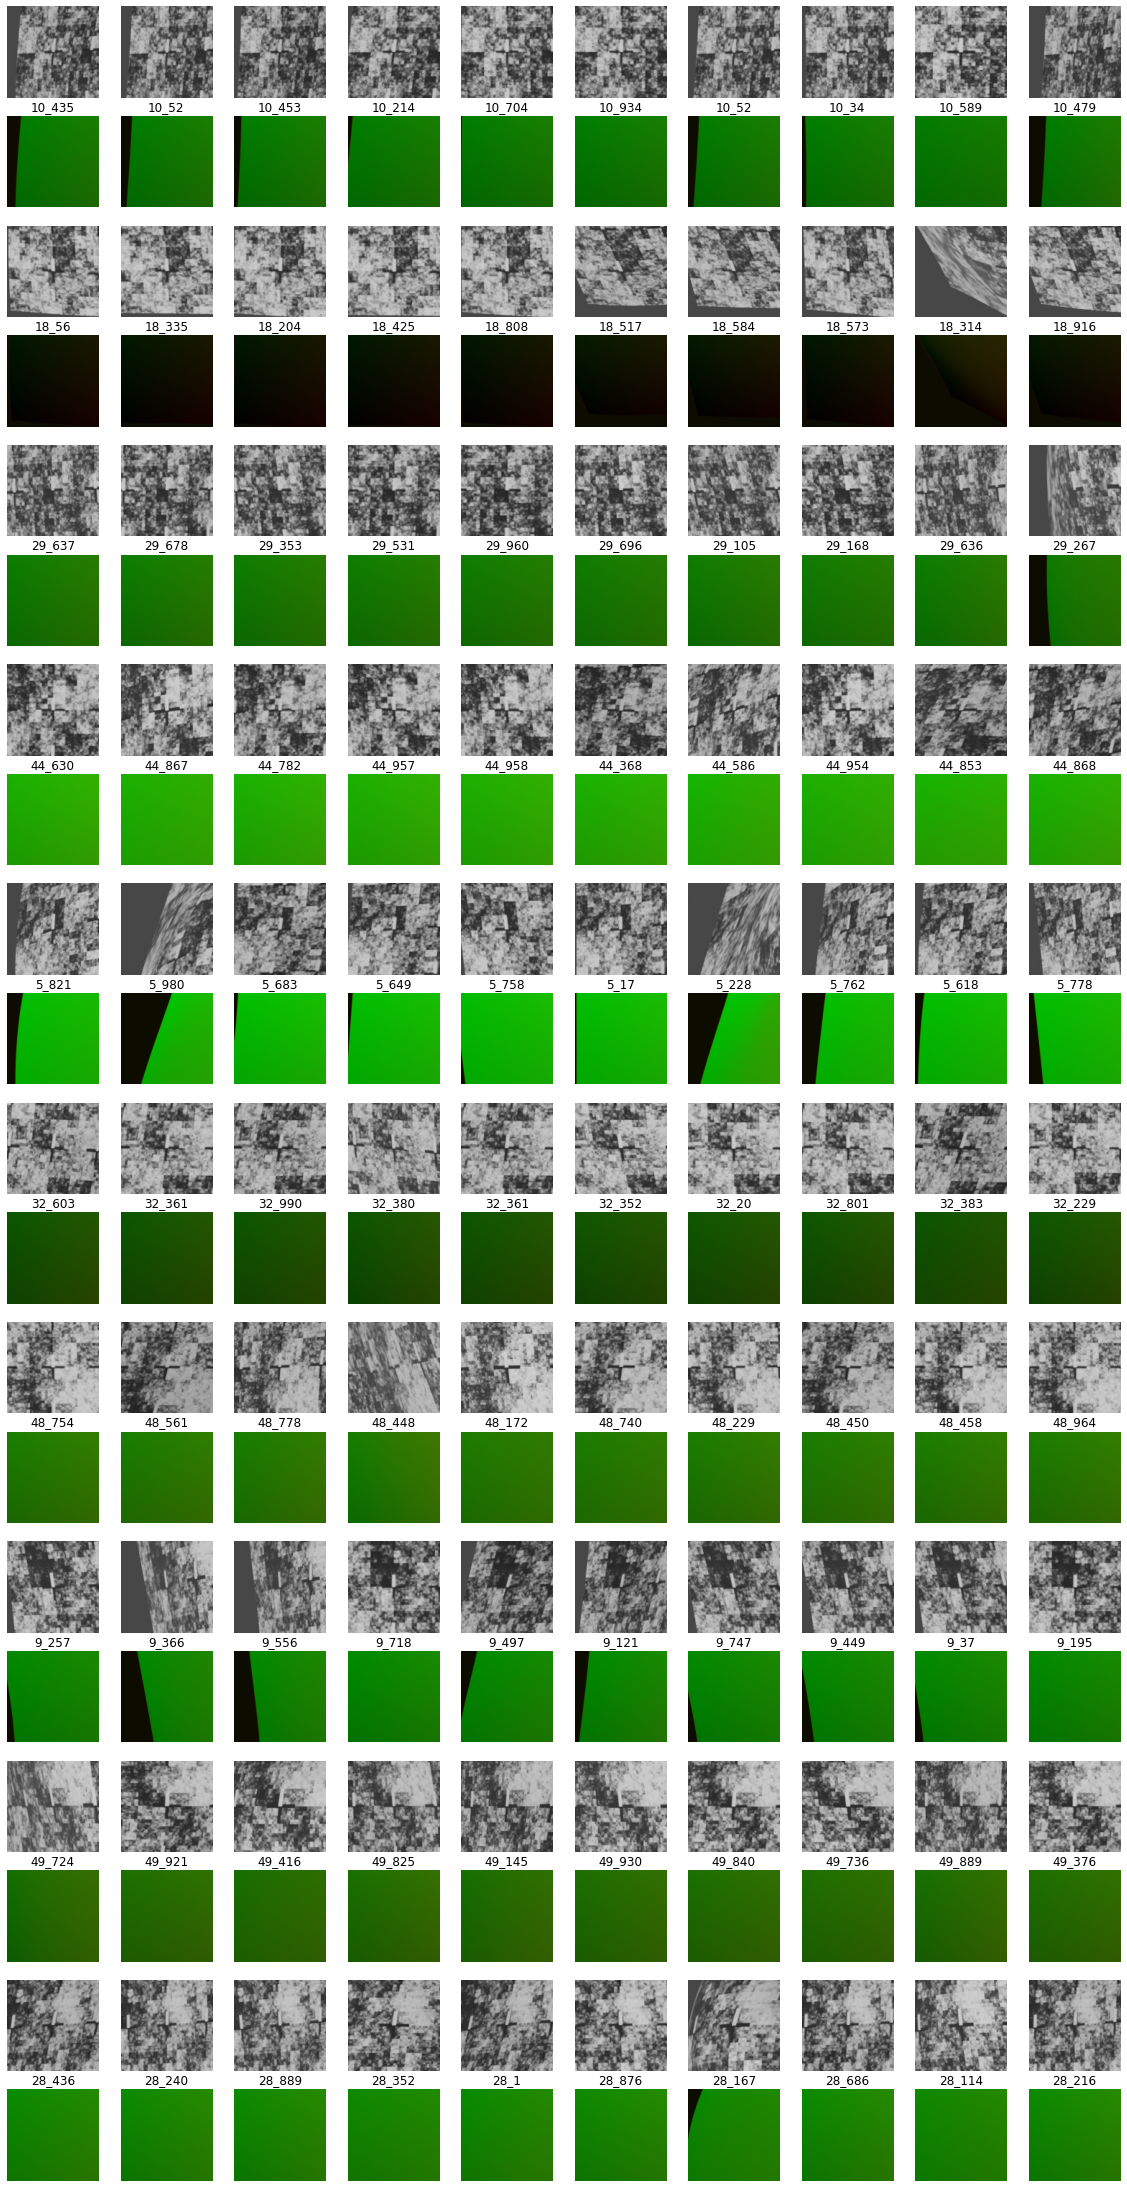

In [7]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)


fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    marker = np.random.randint(0, len(imgsPerMaker))
    imgIds = np.random.randint(0, len(imgsPerMaker[marker]), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(imgsPerMaker[marker][iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(uvsPerMaker[marker][iImg, ...]), )
        axs[i*2+1, j].set_title("%d_%d" % (marker, iImg))
        axs[i*2+1, j].axis('off')
    
    
    

In [9]:
# uvExtractor = UVExtractor('resnet_101', training=False,  pre_trained_model=r'C:\Code\MyRepo\00_DeepLearning\DeepLab-V3\data\models\pretrained\resnet_101\resnet_v2_101.ckpt')
uvExtractor = UVExtractor('resnet_50', training=True, inputShape=[None,128,128,3], labelShape=[None, 128,128,2])

In [10]:
fd = {uvExtractor.inputs:imgsPerMaker[0][:10, :,:,:],
      uvExtractor.is_training:False,
      uvExtractor.target_width:128,
      uvExtractor.target_height:128,
      uvExtractor.labels:uvsPerMaker[0][:10, ...]
     }
featureMap = uvExtractor.sess.run(uvExtractor.outputs, feed_dict=fd)
print(featureMap.shape)

(10, 32, 32, 2)


In [11]:
np.max(uv[..., 0]) - np.min(uv[..., 0])

0.2878467144910246

In [12]:
numData = imgsPerMaker[markerSelected].shape[0]
sizeTrain = numData - numTest

trainData = imgsPerMaker[markerSelected][:-numTest, ...]
trainUV = uvsPerMaker[markerSelected][:-numTest, ...]

testData = imgsPerMaker[markerSelected][-numTest:, ...]
testUV = uvsPerMaker[markerSelected][-numTest:, ...]

errInfo={
    'Train':[],
    'Validation':[]

}

In [13]:
saver = tf.train.Saver()

os.makedirs(outputFolder, exist_ok=True)
logFile = join(outputFolder, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [14]:
numEpoch = 50000
batchSize = 32
weight_decay = 5e-4
lr = 1e-4
saveStep = 500
iEpoch = 0
plotStep = 10

numBatch = int(np.ceil(sizeTrain / batchSize))

cfg = Config()

cfg.lrDecayStep = numBatch * 300
cfg.lrDecayRate = 0.5

uvExtractor.cfg = cfg


In [16]:
bestValErr= 100000

In [17]:

while iEpoch < numEpoch:
    for iBatch in range(numBatch):
        fd = {uvExtractor.inputs:trainData[iBatch*batchSize:(iBatch+1)*batchSize, :,:,:],
              uvExtractor.is_training:True,
              uvExtractor.target_width:128,
              uvExtractor.target_height:128,
              uvExtractor.labels:trainUV[iBatch*batchSize:(iBatch+1)*batchSize, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        _ = uvExtractor.sess.run(uvExtractor.optimizer, feed_dict=fd)

    
    evalTrain = evaluate(trainData, trainUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    evalTest = evaluate(testData, testUV, uvExtractor, batchSize=batchSize, perImgEval=False)    
    errInfo['Train'].append(evalTrain)
    errInfo['Validation'].append(evalTest)
    
    if not iEpoch % saveStep:
        save_path = saver.save(uvExtractor.sess, join(outputFolder, "N03_UVExtractor_128_"+str(iEpoch).zfill(6)+".ckpt"))
        print("Saved check point to: ", save_path)
        
    infoStr = f'mean train err: %8.8g, max train err: %8.8g, mean val err: %8.8g, max val err:  %8.8g, learning rate: %8.8g' \
        % (evalTrain['MeanErr'], evalTrain['MaxErr'], evalTest['MeanErr'],  evalTest['MaxErr'], uvExtractor.sess.run(uvExtractor.learning_rate_decayed, feed_dict=fd))
    
    logger.info(infoStr)
    
    if bestValErr > evalTest['MeanErr']:
        bestValErr = evalTest['MeanErr']
        save_path = saver.save(uvExtractor.sess, join(outputFolder, "N03_UVExtractor_128_best.ckpt"))
        print("Saved new best net's check point to: ", save_path)
        
        
    if iEpoch % plotStep == 0 and i:
        print(infoStr)
        fig, a_loss = plt.subplots()

        
        json.dump(errInfo, open(join(outputFolder, 'Errors.json'), 'w'))
        
        trainMeanErrs = [err['MeanErr'] for err in  errInfo['Train']]
        valMeanErrs = [err['MeanErr'] for err in errInfo['Validation']]
        plt.close('all')
        X = list(range(len(trainMeanErrs)))
        a_loss.plot(X, trainMeanErrs, label = "mean training error")
        a_loss.plot(X, valMeanErrs, label = "mean validation error")
        
        a_loss.set_xlabel('iteration')
        # Set the y axis label of the current axis.
        a_loss.set_ylabel('mean localiztion error')
        a_loss.grid()
        a_loss.legend()
        fig.savefig(join(outputFolder,
                         'ErrCurve.png'),
                    dpi=256, transparent=False, bbox_inches='tight', )
        # to do: code to save the network weight with best validation results
        
    iEpoch += 1

2021-03-08 23:01:20,435 logger INFO mean train err: 0.00055347824, max train err: 0.21173415, mean val err: 0.00093411563, max val err:  0.50922973, learning rate: 5.4506618e-06
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt
2021-03-08 23:02:07,029 logger INFO mean train err: 0.00065585327, max train err: 0.2287655, mean val err: 0.0010273218, max val err:  0.50050854, learning rate: 5.4458019e-06
2021-03-08 23:02:38,919 logger INFO mean train err: 0.00071863428, max train err: 0.22740921, mean val err: 0.0011279136, max val err:  0.50918773, learning rate: 5.4409488e-06
2021-03-08 23:03:11,060 logger INFO mean train err: 0.00081498384, max train err: 0.22503146, mean val err: 0.0011457409, max val err:  0.50799236, learning rate: 5.4361008e-06
2021-03-08 23:03:43,607 logger INFO mean train err: 0.00065172077, max train err: 0.21033373, mean val err: 0.0010467391, max val err:  0.50623042, learning rate: 5.4312541e

2021-03-08 23:24:49,599 logger INFO mean train err: 0.00098217221, max train err: 0.22936955, mean val err: 0.0012460425, max val err:  0.49252492, learning rate: 5.2456244e-06
2021-03-08 23:25:21,925 logger INFO mean train err: 0.00093246416, max train err: 0.23837351, mean val err: 0.0012235694, max val err:  0.48711013, learning rate: 5.24095e-06
2021-03-08 23:25:54,264 logger INFO mean train err: 0.00094322523, max train err: 0.22795781, mean val err: 0.0012248929, max val err:  0.49233297, learning rate: 5.2362775e-06
2021-03-08 23:26:26,595 logger INFO mean train err: 0.00091648853, max train err: 0.23464788, mean val err: 0.0012124099, max val err:  0.48991831, learning rate: 5.2316118e-06
2021-03-08 23:26:58,947 logger INFO mean train err: 0.00091617262, max train err: 0.22826233, mean val err: 0.0012094564, max val err:  0.49239926, learning rate: 5.2269475e-06
2021-03-08 23:27:31,275 logger INFO mean train err: 0.00090249844, max train err: 0.2314963, mean val err: 0.00120203

2021-03-08 23:48:34,351 logger INFO mean train err: 0.00078126963, max train err: 0.22546352, mean val err: 0.0010524712, max val err:  0.50221839, learning rate: 5.043802e-06
2021-03-08 23:49:06,695 logger INFO mean train err: 0.00078006793, max train err: 0.22539325, mean val err: 0.0010503663, max val err:  0.50231469, learning rate: 5.039306e-06
2021-03-08 23:49:38,974 logger INFO mean train err: 0.00077848478, max train err: 0.22528035, mean val err: 0.0010479158, max val err:  0.50243276, learning rate: 5.0348149e-06
mean train err: 0.00077848478, max train err: 0.22528035, mean val err: 0.0010479158, max val err:  0.50243276, learning rate: 5.0348149e-06
2021-03-08 23:50:11,760 logger INFO mean train err: 0.00077696157, max train err: 0.22529458, mean val err: 0.0010453872, max val err:  0.50247428, learning rate: 5.0303265e-06
2021-03-08 23:50:44,085 logger INFO mean train err: 0.00077526146, max train err: 0.22521938, mean val err: 0.001043471, max val err:  0.50255925, learni

2021-03-09 00:11:46,629 logger INFO mean train err: 0.00068247015, max train err: 0.21829662, mean val err: 0.00095861516, max val err:  0.50354391, learning rate: 4.8540701e-06
2021-03-09 00:12:18,958 logger INFO mean train err: 0.00068283553, max train err: 0.21565785, mean val err: 0.00095714384, max val err:  0.5031061, learning rate: 4.8497432e-06
2021-03-09 00:12:51,279 logger INFO mean train err: 0.00069516343, max train err: 0.229942, mean val err: 0.00096436057, max val err:  0.5018625, learning rate: 4.8454212e-06
2021-03-09 00:13:23,638 logger INFO mean train err: 0.0006924768, max train err: 0.23765842, mean val err: 0.0009768115, max val err:  0.50359346, learning rate: 4.8411016e-06
2021-03-09 00:13:56,005 logger INFO mean train err: 0.00068339134, max train err: 0.22007612, mean val err: 0.00095947136, max val err:  0.50455015, learning rate: 4.8367874e-06
2021-03-09 00:14:28,359 logger INFO mean train err: 0.00071703242, max train err: 0.20704674, mean val err: 0.000983

2021-03-09 00:35:31,158 logger INFO mean train err: 0.0015347292, max train err: 0.33438948, mean val err: 0.0016530577, max val err:  0.46380054, learning rate: 4.6673117e-06
2021-03-09 00:36:03,443 logger INFO mean train err: 0.0010823407, max train err: 0.27646152, mean val err: 0.0012707443, max val err:  0.51204998, learning rate: 4.6631521e-06
2021-03-09 00:36:35,775 logger INFO mean train err: 0.0012781668, max train err: 0.29855162, mean val err: 0.0014881604, max val err:  0.51236061, learning rate: 4.6589953e-06
2021-03-09 00:37:08,101 logger INFO mean train err: 0.00097322292, max train err: 0.26566695, mean val err: 0.0012096952, max val err:  0.49261582, learning rate: 4.654843e-06
2021-03-09 00:37:40,448 logger INFO mean train err: 0.00093216579, max train err: 0.26193876, mean val err: 0.0011147242, max val err:  0.50304168, learning rate: 4.6506952e-06
2021-03-09 00:38:12,802 logger INFO mean train err: 0.00081724652, max train err: 0.25649786, mean val err: 0.001033709

2021-03-09 00:59:16,193 logger INFO mean train err: 0.00076741009, max train err: 0.22638288, mean val err: 0.0010432121, max val err:  0.50485092, learning rate: 4.4877393e-06
2021-03-09 00:59:48,553 logger INFO mean train err: 0.00077013285, max train err: 0.22108407, mean val err: 0.0010464756, max val err:  0.5053991, learning rate: 4.4837398e-06
mean train err: 0.00077013285, max train err: 0.22108407, mean val err: 0.0010464756, max val err:  0.5053991, learning rate: 4.4837398e-06
2021-03-09 01:00:21,334 logger INFO mean train err: 0.00076735786, max train err: 0.21652244, mean val err: 0.0010434381, max val err:  0.50346595, learning rate: 4.479743e-06
2021-03-09 01:00:53,662 logger INFO mean train err: 0.00076247609, max train err: 0.22561227, mean val err: 0.0010368872, max val err:  0.50326187, learning rate: 4.4757508e-06
2021-03-09 01:01:26,061 logger INFO mean train err: 0.00075237733, max train err: 0.22813036, mean val err: 0.0010285861, max val err:  0.50600103, learni

2021-03-09 01:22:15,192 logger INFO mean train err: 0.00069992413, max train err: 0.22619168, mean val err: 0.0010106383, max val err:  0.51023662, learning rate: 4.3227783e-06
2021-03-09 01:22:47,565 logger INFO mean train err: 0.0009246203, max train err: 0.22544086, mean val err: 0.00120319, max val err:  0.50503942, learning rate: 4.3189248e-06
2021-03-09 01:23:19,969 logger INFO mean train err: 0.0007488816, max train err: 0.21325609, mean val err: 0.0010445369, max val err:  0.50790816, learning rate: 4.3150762e-06
2021-03-09 01:23:52,273 logger INFO mean train err: 0.00094626241, max train err: 0.22566364, mean val err: 0.0012302539, max val err:  0.50305372, learning rate: 4.3112291e-06
2021-03-09 01:24:24,646 logger INFO mean train err: 0.00078386246, max train err: 0.22650411, mean val err: 0.001087156, max val err:  0.51194975, learning rate: 4.3073874e-06
2021-03-09 01:24:57,061 logger INFO mean train err: 0.0009502032, max train err: 0.22401468, mean val err: 0.0012250772,

2021-03-09 01:45:45,177 logger INFO mean train err: 0.00062016486, max train err: 0.21939047, mean val err: 0.00096825311, max val err:  0.50368353, learning rate: 4.1601688e-06
2021-03-09 01:46:17,491 logger INFO mean train err: 0.00062412081, max train err: 0.24007443, mean val err: 0.0010520636, max val err:  0.51102515, learning rate: 4.1564599e-06
2021-03-09 01:46:49,833 logger INFO mean train err: 0.00061137105, max train err: 0.2241754, mean val err: 0.0010406084, max val err:  0.51171237, learning rate: 4.1527564e-06
2021-03-09 01:47:22,213 logger INFO mean train err: 0.00070584239, max train err: 0.21602189, mean val err: 0.0010549585, max val err:  0.50271734, learning rate: 4.1490543e-06
2021-03-09 01:47:54,552 logger INFO mean train err: 0.00058741435, max train err: 0.22274842, mean val err: 0.00093519291, max val err:  0.50434332, learning rate: 4.1453573e-06
2021-03-09 01:48:26,957 logger INFO mean train err: 0.00067146889, max train err: 0.24258589, mean val err: 0.0011

2021-03-09 02:09:30,110 logger INFO mean train err: 0.00090257246, max train err: 0.21705895, mean val err: 0.0011278853, max val err:  0.50191524, learning rate: 4.0001078e-06
2021-03-09 02:10:02,407 logger INFO mean train err: 0.00096988199, max train err: 0.22869551, mean val err: 0.0011126978, max val err:  0.50637007, learning rate: 3.996543e-06
2021-03-09 02:10:34,760 logger INFO mean train err: 0.0011166221, max train err: 0.22172321, mean val err: 0.0011356364, max val err:  0.50251715, learning rate: 3.9929801e-06
mean train err: 0.0011166221, max train err: 0.22172321, mean val err: 0.0011356364, max val err:  0.50251715, learning rate: 3.9929801e-06
2021-03-09 02:11:07,556 logger INFO mean train err: 0.001172054, max train err: 0.2162355, mean val err: 0.0011315933, max val err:  0.50016855, learning rate: 3.9894217e-06
2021-03-09 02:11:39,896 logger INFO mean train err: 0.0012371612, max train err: 0.2210974, mean val err: 0.0015237423, max val err:  0.50385839, learning ra

2021-03-09 02:32:42,166 logger INFO mean train err: 0.0014014406, max train err: 0.22523454, mean val err: 0.0017172254, max val err:  0.50750148, learning rate: 3.8496364e-06
2021-03-09 02:33:14,433 logger INFO mean train err: 0.0012244736, max train err: 0.21875366, mean val err: 0.0015836874, max val err:  0.5025466, learning rate: 3.8462058e-06
2021-03-09 02:33:46,714 logger INFO mean train err: 0.0012720161, max train err: 0.22824565, mean val err: 0.0016540686, max val err:  0.50215732, learning rate: 3.842777e-06
2021-03-09 02:34:18,970 logger INFO mean train err: 0.0014545548, max train err: 0.23584114, mean val err: 0.0018436603, max val err:  0.51268124, learning rate: 3.8393528e-06
2021-03-09 02:34:51,242 logger INFO mean train err: 0.0014334106, max train err: 0.22633471, mean val err: 0.0018015953, max val err:  0.51337026, learning rate: 3.8359312e-06
2021-03-09 02:35:23,632 logger INFO mean train err: 0.0015841609, max train err: 0.217926, mean val err: 0.0019267571, max

Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt
2021-03-09 02:55:48,917 logger INFO mean train err: 0.00048917217, max train err: 0.23329789, mean val err: 0.00063985272, max val err:  0.49309641, learning rate: 3.7180635e-06
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt
mean train err: 0.00048917217, max train err: 0.23329789, mean val err: 0.00063985272, max val err:  0.49309641, learning rate: 3.7180635e-06
2021-03-09 02:56:35,661 logger INFO mean train err: 0.0004859903, max train err: 0.23024069, mean val err: 0.00063767181, max val err:  0.492918, learning rate: 3.7147502e-06
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt
2021-03-09 02:57:21,682 logger INFO mean train err: 0.0004835726, max train err: 0.22800833, mean val err: 0.0006356472, max val err:  0.49244786, l

2021-03-09 03:16:52,162 logger INFO mean train err: 0.00048235651, max train err: 0.22088215, mean val err: 0.00063815843, max val err:  0.49510133, learning rate: 3.6134718e-06
2021-03-09 03:17:24,467 logger INFO mean train err: 0.00048699742, max train err: 0.2208377, mean val err: 0.0006414684, max val err:  0.49501389, learning rate: 3.6102517e-06
2021-03-09 03:17:56,745 logger INFO mean train err: 0.00049201957, max train err: 0.22100704, mean val err: 0.00064532096, max val err:  0.49508889, learning rate: 3.607033e-06
2021-03-09 03:18:29,013 logger INFO mean train err: 0.00049845414, max train err: 0.22073323, mean val err: 0.00065023314, max val err:  0.49513055, learning rate: 3.6038189e-06
2021-03-09 03:19:01,360 logger INFO mean train err: 0.00050521728, max train err: 0.22029491, mean val err: 0.00065553889, max val err:  0.49503986, learning rate: 3.6006059e-06
2021-03-09 03:19:33,655 logger INFO mean train err: 0.00051352698, max train err: 0.22030499, mean val err: 0.000

2021-03-09 03:40:03,785 logger INFO mean train err: 0.00052482146, max train err: 0.21827242, mean val err: 0.00065944342, max val err:  0.49525001, learning rate: 3.4775442e-06
2021-03-09 03:40:36,145 logger INFO mean train err: 0.00051838651, max train err: 0.21936936, mean val err: 0.00065707027, max val err:  0.49650946, learning rate: 3.4744455e-06
2021-03-09 03:41:08,486 logger INFO mean train err: 0.00052756559, max train err: 0.21772315, mean val err: 0.00065928868, max val err:  0.49580769, learning rate: 3.471348e-06
2021-03-09 03:41:40,822 logger INFO mean train err: 0.00051653111, max train err: 0.21551264, mean val err: 0.00065476363, max val err:  0.49591773, learning rate: 3.4682546e-06
2021-03-09 03:42:13,162 logger INFO mean train err: 0.00055085966, max train err: 0.21903249, mean val err: 0.00067400113, max val err:  0.49518468, learning rate: 3.4651628e-06
2021-03-09 03:42:45,505 logger INFO mean train err: 0.00053353122, max train err: 0.21847106, mean val err: 0.0

2021-03-09 04:03:16,364 logger INFO mean train err: 0.00060689264, max train err: 0.21247831, mean val err: 0.00073129319, max val err:  0.49075947, learning rate: 3.34673e-06
2021-03-09 04:03:48,662 logger INFO mean train err: 0.00072500149, max train err: 0.22684578, mean val err: 0.00081814132, max val err:  0.49318403, learning rate: 3.3437479e-06
2021-03-09 04:04:20,932 logger INFO mean train err: 0.00064595834, max train err: 0.23145627, mean val err: 0.000761223, max val err:  0.49767348, learning rate: 3.3407669e-06
mean train err: 0.00064595834, max train err: 0.23145627, mean val err: 0.000761223, max val err:  0.49767348, learning rate: 3.3407669e-06
2021-03-09 04:04:53,843 logger INFO mean train err: 0.00068399111, max train err: 0.21914577, mean val err: 0.00078832864, max val err:  0.4947041, learning rate: 3.3377896e-06
2021-03-09 04:05:26,154 logger INFO mean train err: 0.00063066533, max train err: 0.21355956, mean val err: 0.00073871465, max val err:  0.49347978, lear

2021-03-09 04:26:29,004 logger INFO mean train err: 0.00062502935, max train err: 0.21752078, mean val err: 0.00099932338, max val err:  0.54151854, learning rate: 3.220837e-06
2021-03-09 04:27:01,379 logger INFO mean train err: 0.00062371078, max train err: 0.21697155, mean val err: 0.0010013175, max val err:  0.54031403, learning rate: 3.2179669e-06
2021-03-09 04:27:33,690 logger INFO mean train err: 0.00063168284, max train err: 0.21641817, mean val err: 0.0010068059, max val err:  0.54080576, learning rate: 3.2150979e-06
2021-03-09 04:28:06,073 logger INFO mean train err: 0.00063389721, max train err: 0.21728221, mean val err: 0.0010122143, max val err:  0.53991283, learning rate: 3.2122325e-06
2021-03-09 04:28:38,360 logger INFO mean train err: 0.00064312092, max train err: 0.21736504, mean val err: 0.001018919, max val err:  0.54057858, learning rate: 3.2093703e-06
2021-03-09 04:29:10,675 logger INFO mean train err: 0.00064384415, max train err: 0.21686772, mean val err: 0.001024

2021-03-09 04:50:12,701 logger INFO mean train err: 0.00064854709, max train err: 0.21671707, mean val err: 0.0011036634, max val err:  0.50353402, learning rate: 3.096917e-06
2021-03-09 04:50:45,055 logger INFO mean train err: 0.00066081734, max train err: 0.21659379, mean val err: 0.0011151161, max val err:  0.50269285, learning rate: 3.0941571e-06
2021-03-09 04:51:17,411 logger INFO mean train err: 0.00065796313, max train err: 0.2169913, mean val err: 0.0011264614, max val err:  0.50383829, learning rate: 3.0913986e-06
2021-03-09 04:51:49,745 logger INFO mean train err: 0.00066859645, max train err: 0.21630937, mean val err: 0.0011348677, max val err:  0.50328809, learning rate: 3.0886438e-06
2021-03-09 04:52:22,065 logger INFO mean train err: 0.00066968021, max train err: 0.21737138, mean val err: 0.0011485811, max val err:  0.50407222, learning rate: 3.0858903e-06
2021-03-09 04:52:54,331 logger INFO mean train err: 0.00067758434, max train err: 0.21598529, mean val err: 0.0011557

2021-03-09 05:13:55,885 logger INFO mean train err: 0.0010427233, max train err: 0.2174741, mean val err: 0.0017770407, max val err:  0.49886646, learning rate: 2.9777648e-06
2021-03-09 05:14:28,272 logger INFO mean train err: 0.00072560933, max train err: 0.21301296, mean val err: 0.0015249246, max val err:  0.50296868, learning rate: 2.9751102e-06
mean train err: 0.00072560933, max train err: 0.21301296, mean val err: 0.0015249246, max val err:  0.50296868, learning rate: 2.9751102e-06
2021-03-09 05:15:01,133 logger INFO mean train err: 0.00070376031, max train err: 0.21772875, mean val err: 0.0014971628, max val err:  0.49889119, learning rate: 2.972459e-06
2021-03-09 05:15:33,451 logger INFO mean train err: 0.00075254158, max train err: 0.21235672, mean val err: 0.0015147059, max val err:  0.50313287, learning rate: 2.969809e-06
2021-03-09 05:16:05,739 logger INFO mean train err: 0.00082798962, max train err: 0.21731832, mean val err: 0.0015631177, max val err:  0.49885571, learnin

2021-03-09 05:37:07,583 logger INFO mean train err: 0.0005056073, max train err: 0.22046567, mean val err: 0.00075854498, max val err:  0.50500817, learning rate: 2.8657507e-06
2021-03-09 05:37:39,946 logger INFO mean train err: 0.00050909562, max train err: 0.21949694, mean val err: 0.00075786609, max val err:  0.50452718, learning rate: 2.8631957e-06
2021-03-09 05:38:12,254 logger INFO mean train err: 0.00051075351, max train err: 0.21933596, mean val err: 0.00075835143, max val err:  0.50527568, learning rate: 2.8606446e-06
2021-03-09 05:38:44,578 logger INFO mean train err: 0.00051477893, max train err: 0.21880212, mean val err: 0.00075907731, max val err:  0.50476228, learning rate: 2.8580946e-06
2021-03-09 05:39:16,949 logger INFO mean train err: 0.0005173477, max train err: 0.21983335, mean val err: 0.00075943315, max val err:  0.50556644, learning rate: 2.8555473e-06
2021-03-09 05:39:49,273 logger INFO mean train err: 0.00052208591, max train err: 0.21926184, mean val err: 0.00

2021-03-09 06:00:36,430 logger INFO mean train err: 0.0017766974, max train err: 0.2334692, mean val err: 0.0018856274, max val err:  0.49410715, learning rate: 2.7579504e-06
2021-03-09 06:01:08,720 logger INFO mean train err: 0.0011515996, max train err: 0.27577722, mean val err: 0.0014161947, max val err:  0.51195883, learning rate: 2.7554918e-06
2021-03-09 06:01:40,946 logger INFO mean train err: 0.0010227631, max train err: 0.26225862, mean val err: 0.0014123007, max val err:  0.5390862, learning rate: 2.7530359e-06
2021-03-09 06:02:13,235 logger INFO mean train err: 0.00095063349, max train err: 0.24750225, mean val err: 0.0011849012, max val err:  0.5157103, learning rate: 2.7505819e-06
2021-03-09 06:02:45,528 logger INFO mean train err: 0.0012890194, max train err: 0.22846098, mean val err: 0.0014255038, max val err:  0.52469856, learning rate: 2.7481308e-06
2021-03-09 06:03:17,788 logger INFO mean train err: 0.0015919337, max train err: 0.24800588, mean val err: 0.0017835597, m

2021-03-09 06:24:19,317 logger INFO mean train err: 0.00059825441, max train err: 0.22007658, mean val err: 0.00072582551, max val err:  0.53915735, learning rate: 2.6518389e-06
2021-03-09 06:24:51,641 logger INFO mean train err: 0.00059160331, max train err: 0.22383679, mean val err: 0.00068568323, max val err:  0.53280348, learning rate: 2.6494758e-06
mean train err: 0.00059160331, max train err: 0.22383679, mean val err: 0.00068568323, max val err:  0.53280348, learning rate: 2.6494758e-06
2021-03-09 06:25:24,495 logger INFO mean train err: 0.0005850113, max train err: 0.21775672, mean val err: 0.00067759095, max val err:  0.53449193, learning rate: 2.6471148e-06
2021-03-09 06:25:56,770 logger INFO mean train err: 0.0005895058, max train err: 0.22705706, mean val err: 0.00068983069, max val err:  0.53625836, learning rate: 2.6447547e-06
2021-03-09 06:26:29,075 logger INFO mean train err: 0.00058258922, max train err: 0.2269691, mean val err: 0.00066632068, max val err:  0.5348237, l

2021-03-09 06:47:32,259 logger INFO mean train err: 0.0008174549, max train err: 0.21535078, mean val err: 0.00074318784, max val err:  0.53293755, learning rate: 2.552086e-06
2021-03-09 06:48:04,540 logger INFO mean train err: 0.00084502658, max train err: 0.21481384, mean val err: 0.00074653791, max val err:  0.53571434, learning rate: 2.5498109e-06
2021-03-09 06:48:36,894 logger INFO mean train err: 0.00085085167, max train err: 0.2279675, mean val err: 0.00075425623, max val err:  0.54124354, learning rate: 2.5475385e-06
2021-03-09 06:49:09,119 logger INFO mean train err: 0.00089539793, max train err: 0.22266933, mean val err: 0.00076524521, max val err:  0.53683789, learning rate: 2.5452675e-06
2021-03-09 06:49:41,428 logger INFO mean train err: 0.00097608573, max train err: 0.2109224, mean val err: 0.0008030568, max val err:  0.53566884, learning rate: 2.5429993e-06
2021-03-09 06:50:13,697 logger INFO mean train err: 0.0010252774, max train err: 0.22408082, mean val err: 0.000849

2021-03-09 07:11:16,139 logger INFO mean train err: 0.00046308138, max train err: 0.22342211, mean val err: 0.00064296795, max val err:  0.54308462, learning rate: 2.4538951e-06
2021-03-09 07:11:48,449 logger INFO mean train err: 0.00045449905, max train err: 0.22706213, mean val err: 0.00064263219, max val err:  0.54037053, learning rate: 2.4517083e-06
2021-03-09 07:12:20,831 logger INFO mean train err: 0.00046274421, max train err: 0.22215604, mean val err: 0.00064195225, max val err:  0.54304205, learning rate: 2.4495228e-06
2021-03-09 07:12:53,107 logger INFO mean train err: 0.000453775, max train err: 0.2256966, mean val err: 0.00064193533, max val err:  0.54017287, learning rate: 2.4473397e-06
2021-03-09 07:13:25,437 logger INFO mean train err: 0.00046357435, max train err: 0.22279857, mean val err: 0.00064237229, max val err:  0.54321194, learning rate: 2.4451581e-06
mean train err: 0.00046357435, max train err: 0.22279857, mean val err: 0.00064237229, max val err:  0.54321194, 

2021-03-09 07:34:28,376 logger INFO mean train err: 0.00068551285, max train err: 0.21361027, mean val err: 0.00087453169, max val err:  0.53623903, learning rate: 2.3615873e-06
2021-03-09 07:35:00,662 logger INFO mean train err: 0.00094414577, max train err: 0.21611861, mean val err: 0.0010819612, max val err:  0.53776256, learning rate: 2.3594832e-06
mean train err: 0.00094414577, max train err: 0.21611861, mean val err: 0.0010819612, max val err:  0.53776256, learning rate: 2.3594832e-06
2021-03-09 07:35:33,483 logger INFO mean train err: 0.0016855391, max train err: 0.26104583, mean val err: 0.0015540574, max val err:  0.55394106, learning rate: 2.3573793e-06
2021-03-09 07:36:05,781 logger INFO mean train err: 0.00075022367, max train err: 0.2288588, mean val err: 0.00086180857, max val err:  0.53704113, learning rate: 2.3552789e-06
2021-03-09 07:36:38,043 logger INFO mean train err: 0.00075024241, max train err: 0.23643093, mean val err: 0.00093412969, max val err:  0.52131145, le

2021-03-09 07:57:39,038 logger INFO mean train err: 0.00055533126, max train err: 0.37788957, mean val err: 0.00089957875, max val err:  0.45944116, learning rate: 2.2727522e-06
2021-03-09 07:58:11,359 logger INFO mean train err: 0.000566744, max train err: 0.36987394, mean val err: 0.00084130955, max val err:  0.49164434, learning rate: 2.2707266e-06
2021-03-09 07:58:43,638 logger INFO mean train err: 0.00054526764, max train err: 0.37398249, mean val err: 0.00088279919, max val err:  0.4621343, learning rate: 2.2687025e-06
2021-03-09 07:59:15,923 logger INFO mean train err: 0.00055528101, max train err: 0.3664713, mean val err: 0.00083378534, max val err:  0.49094245, learning rate: 2.2666807e-06
2021-03-09 07:59:48,169 logger INFO mean train err: 0.00053781036, max train err: 0.37055519, mean val err: 0.00087064973, max val err:  0.46426328, learning rate: 2.2646607e-06
2021-03-09 08:00:20,451 logger INFO mean train err: 0.00054698256, max train err: 0.36298609, mean val err: 0.0008

2021-03-09 08:20:50,039 logger INFO mean train err: 0.00054682113, max train err: 0.29719022, mean val err: 0.00082107704, max val err:  0.5000544, learning rate: 2.1872584e-06
2021-03-09 08:21:22,334 logger INFO mean train err: 0.00054845332, max train err: 0.3105604, mean val err: 0.00088199014, max val err:  0.46792837, learning rate: 2.1853093e-06
2021-03-09 08:21:54,686 logger INFO mean train err: 0.00055701687, max train err: 0.29451532, mean val err: 0.00082711152, max val err:  0.5001193, learning rate: 2.1833616e-06
2021-03-09 08:22:27,020 logger INFO mean train err: 0.00055864409, max train err: 0.30848403, mean val err: 0.00087829783, max val err:  0.46693352, learning rate: 2.1814153e-06
2021-03-09 08:22:59,333 logger INFO mean train err: 0.000560339, max train err: 0.29250176, mean val err: 0.00083079764, max val err:  0.50080573, learning rate: 2.1794713e-06
2021-03-09 08:23:31,602 logger INFO mean train err: 0.00055579018, max train err: 0.30698294, mean val err: 0.00089

2021-03-09 08:44:01,894 logger INFO mean train err: 0.00051248961, max train err: 0.27141339, mean val err: 0.00094179869, max val err:  0.47619399, learning rate: 2.1049816e-06
2021-03-09 08:44:34,221 logger INFO mean train err: 0.00053748365, max train err: 0.2587458, mean val err: 0.00090153378, max val err:  0.49687281, learning rate: 2.1031049e-06
2021-03-09 08:45:06,532 logger INFO mean train err: 0.00053901024, max train err: 0.26916294, mean val err: 0.00095345152, max val err:  0.47663127, learning rate: 2.1012308e-06
mean train err: 0.00053901024, max train err: 0.26916294, mean val err: 0.00095345152, max val err:  0.47663127, learning rate: 2.1012308e-06
2021-03-09 08:45:39,395 logger INFO mean train err: 0.00065437289, max train err: 0.25729148, mean val err: 0.0010166014, max val err:  0.49521151, learning rate: 2.0993575e-06
2021-03-09 08:46:11,685 logger INFO mean train err: 0.00067318214, max train err: 0.26491568, mean val err: 0.0010805724, max val err:  0.47880927, 

2021-03-09 09:07:14,944 logger INFO mean train err: 0.00060596707, max train err: 0.25395218, mean val err: 0.00074932845, max val err:  0.5044606, learning rate: 2.0257987e-06
2021-03-09 09:07:47,317 logger INFO mean train err: 0.00059195658, max train err: 0.25316915, mean val err: 0.00073946453, max val err:  0.50431145, learning rate: 2.0239927e-06
2021-03-09 09:08:19,647 logger INFO mean train err: 0.0005875844, max train err: 0.25191341, mean val err: 0.00073616884, max val err:  0.50467583, learning rate: 2.0221892e-06
2021-03-09 09:08:52,031 logger INFO mean train err: 0.00057670102, max train err: 0.25106958, mean val err: 0.00072903856, max val err:  0.50503288, learning rate: 2.0203863e-06
2021-03-09 09:09:24,358 logger INFO mean train err: 0.0005756444, max train err: 0.25027467, mean val err: 0.00072787883, max val err:  0.50489691, learning rate: 2.0185862e-06
2021-03-09 09:09:56,683 logger INFO mean train err: 0.00056647851, max train err: 0.24924186, mean val err: 0.000

2021-03-09 09:30:59,355 logger INFO mean train err: 0.00058921194, max train err: 0.23156316, mean val err: 0.00074785166, max val err:  0.50635307, learning rate: 1.9478566e-06
2021-03-09 09:31:31,700 logger INFO mean train err: 0.00057223639, max train err: 0.23090303, mean val err: 0.00074512045, max val err:  0.50785914, learning rate: 1.9461206e-06
2021-03-09 09:32:04,036 logger INFO mean train err: 0.00058833957, max train err: 0.23160072, mean val err: 0.00074741443, max val err:  0.50606892, learning rate: 1.9443858e-06
2021-03-09 09:32:36,326 logger INFO mean train err: 0.00058598336, max train err: 0.23046965, mean val err: 0.0007564653, max val err:  0.50803514, learning rate: 1.9426532e-06
2021-03-09 09:33:08,656 logger INFO mean train err: 0.00059618701, max train err: 0.23165959, mean val err: 0.00075727972, max val err:  0.50607035, learning rate: 1.9409213e-06
2021-03-09 09:33:40,974 logger INFO mean train err: 0.00059219062, max train err: 0.22969215, mean val err: 0.0

2021-03-09 09:54:11,896 logger INFO mean train err: 0.00059342505, max train err: 0.22699552, mean val err: 0.00074207487, max val err:  0.50911658, learning rate: 1.8745844e-06
2021-03-09 09:54:44,257 logger INFO mean train err: 0.00071561636, max train err: 0.22405844, mean val err: 0.00082738096, max val err:  0.50896868, learning rate: 1.8729139e-06
2021-03-09 09:55:16,534 logger INFO mean train err: 0.00082588603, max train err: 0.22805725, mean val err: 0.00090441496, max val err:  0.50934524, learning rate: 1.8712444e-06
mean train err: 0.00082588603, max train err: 0.22805725, mean val err: 0.00090441496, max val err:  0.50934524, learning rate: 1.8712444e-06
2021-03-09 09:55:49,382 logger INFO mean train err: 0.0010092676, max train err: 0.22931859, mean val err: 0.0010564722, max val err:  0.51005192, learning rate: 1.8695767e-06
2021-03-09 09:56:21,710 logger INFO mean train err: 0.0010346224, max train err: 0.22427345, mean val err: 0.0010840728, max val err:  0.50885435, l

mean train err: 0.00091357289, max train err: 0.22922294, mean val err: 0.0012307672, max val err:  0.52368812, learning rate: 1.8056784e-06
2021-03-09 10:17:38,083 logger INFO mean train err: 0.0010408292, max train err: 0.22340149, mean val err: 0.0012237614, max val err:  0.51892136, learning rate: 1.8040687e-06
2021-03-09 10:18:10,461 logger INFO mean train err: 0.0014591521, max train err: 0.22391309, mean val err: 0.0017139622, max val err:  0.52683847, learning rate: 1.802461e-06
2021-03-09 10:18:43,386 logger INFO mean train err: 0.0015379118, max train err: 0.22762199, mean val err: 0.0017425927, max val err:  0.52935853, learning rate: 1.8008546e-06
2021-03-09 10:19:16,485 logger INFO mean train err: 0.0012845476, max train err: 0.22621967, mean val err: 0.0015335132, max val err:  0.52240138, learning rate: 1.7992493e-06
2021-03-09 10:19:49,485 logger INFO mean train err: 0.0016566508, max train err: 0.21777466, mean val err: 0.0018813226, max val err:  0.5250032, learning r

2021-03-09 10:40:53,938 logger INFO mean train err: 0.00044869972, max train err: 0.22205329, mean val err: 0.00091584042, max val err:  0.51333576, learning rate: 1.7362053e-06
2021-03-09 10:41:26,263 logger INFO mean train err: 0.00043458545, max train err: 0.22223656, mean val err: 0.00094137109, max val err:  0.51337747, learning rate: 1.7346579e-06
2021-03-09 10:41:58,637 logger INFO mean train err: 0.00042926303, max train err: 0.22272853, mean val err: 0.0009698758, max val err:  0.51302146, learning rate: 1.7331123e-06
2021-03-09 10:42:31,009 logger INFO mean train err: 0.00042910504, max train err: 0.22280502, mean val err: 0.00099587544, max val err:  0.51288513, learning rate: 1.7315671e-06
2021-03-09 10:43:03,356 logger INFO mean train err: 0.00043514532, max train err: 0.22337674, mean val err: 0.0010238824, max val err:  0.51242188, learning rate: 1.730024e-06
2021-03-09 10:43:35,732 logger INFO mean train err: 0.00043989458, max train err: 0.22341806, mean val err: 0.001

2021-03-09 11:04:38,661 logger INFO mean train err: 0.001073837, max train err: 0.23155225, mean val err: 0.0014459147, max val err:  0.50787205, learning rate: 1.6694057e-06
2021-03-09 11:05:10,969 logger INFO mean train err: 0.0011213653, max train err: 0.21237058, mean val err: 0.0019873863, max val err:  0.49142419, learning rate: 1.667918e-06
2021-03-09 11:05:43,265 logger INFO mean train err: 0.00098370989, max train err: 0.22752895, mean val err: 0.0012307573, max val err:  0.481284, learning rate: 1.6664311e-06
mean train err: 0.00098370989, max train err: 0.22752895, mean val err: 0.0012307573, max val err:  0.481284, learning rate: 1.6664311e-06
2021-03-09 11:06:16,141 logger INFO mean train err: 0.00099435525, max train err: 0.34285756, mean val err: 0.0011864392, max val err:  0.43823495, learning rate: 1.6649462e-06
2021-03-09 11:06:48,496 logger INFO mean train err: 0.00072563699, max train err: 0.31051966, mean val err: 0.00089194081, max val err:  0.47001466, learning r

2021-03-09 11:27:52,443 logger INFO mean train err: 0.00056642504, max train err: 0.21680738, mean val err: 0.0007554928, max val err:  0.48801874, learning rate: 1.6066082e-06
2021-03-09 11:28:24,767 logger INFO mean train err: 0.0005120062, max train err: 0.21654236, mean val err: 0.00070274574, max val err:  0.48955443, learning rate: 1.6051763e-06
2021-03-09 11:28:57,085 logger INFO mean train err: 0.00055440081, max train err: 0.24104885, mean val err: 0.00075647067, max val err:  0.49250165, learning rate: 1.6037452e-06
2021-03-09 11:29:29,438 logger INFO mean train err: 0.00049466126, max train err: 0.22883192, mean val err: 0.00070647388, max val err:  0.49399971, learning rate: 1.602316e-06
2021-03-09 11:30:01,825 logger INFO mean train err: 0.00056682924, max train err: 0.21579419, mean val err: 0.00076207115, max val err:  0.48836046, learning rate: 1.6008878e-06
2021-03-09 11:30:34,241 logger INFO mean train err: 0.00059149678, max train err: 0.21965501, mean val err: 0.000

2021-03-09 11:51:37,327 logger INFO mean train err: 0.00056192556, max train err: 0.21908067, mean val err: 0.00079188772, max val err:  0.50526823, learning rate: 1.5447946e-06
2021-03-09 11:52:09,724 logger INFO mean train err: 0.00058061056, max train err: 0.22529958, mean val err: 0.00082133941, max val err:  0.50696723, learning rate: 1.5434174e-06
2021-03-09 11:52:42,010 logger INFO mean train err: 0.00055547767, max train err: 0.22175864, mean val err: 0.00080094139, max val err:  0.50683581, learning rate: 1.5420421e-06
2021-03-09 11:53:14,340 logger INFO mean train err: 0.00054522928, max train err: 0.22058922, mean val err: 0.00079034793, max val err:  0.50593227, learning rate: 1.5406679e-06
2021-03-09 11:53:46,675 logger INFO mean train err: 0.0005439345, max train err: 0.22069181, mean val err: 0.00079500977, max val err:  0.50660559, learning rate: 1.5392944e-06
2021-03-09 11:54:18,998 logger INFO mean train err: 0.00053753717, max train err: 0.22212039, mean val err: 0.0

2021-03-09 12:14:50,700 logger INFO mean train err: 0.00056428243, max train err: 0.21888332, mean val err: 0.00079193181, max val err:  0.50346611, learning rate: 1.4866844e-06
2021-03-09 12:15:22,960 logger INFO mean train err: 0.00057407203, max train err: 0.22019915, mean val err: 0.00080152894, max val err:  0.50326262, learning rate: 1.4853596e-06
2021-03-09 12:15:55,260 logger INFO mean train err: 0.0005792176, max train err: 0.22000872, mean val err: 0.00080699812, max val err:  0.50322659, learning rate: 1.4840354e-06
mean train err: 0.0005792176, max train err: 0.22000872, mean val err: 0.00080699812, max val err:  0.50322659, learning rate: 1.4840354e-06
2021-03-09 12:16:28,215 logger INFO mean train err: 0.0005822553, max train err: 0.21794312, mean val err: 0.00080872548, max val err:  0.50303135, learning rate: 1.4827129e-06
2021-03-09 12:17:00,532 logger INFO mean train err: 0.0005893327, max train err: 0.21701912, mean val err: 0.00081370617, max val err:  0.50250702, l

2021-03-09 12:38:03,714 logger INFO mean train err: 0.00064330529, max train err: 0.21926726, mean val err: 0.0010365064, max val err:  0.49631129, learning rate: 1.4307601e-06
2021-03-09 12:38:36,033 logger INFO mean train err: 0.00059541436, max train err: 0.22499206, mean val err: 0.00094792056, max val err:  0.4985465, learning rate: 1.429485e-06
2021-03-09 12:39:08,357 logger INFO mean train err: 0.00056253232, max train err: 0.21784144, mean val err: 0.00091108632, max val err:  0.49804149, learning rate: 1.4282107e-06
2021-03-09 12:39:40,645 logger INFO mean train err: 0.00056415472, max train err: 0.21488363, mean val err: 0.00090720831, max val err:  0.49589319, learning rate: 1.4269381e-06
2021-03-09 12:40:12,959 logger INFO mean train err: 0.00052994, max train err: 0.21772884, mean val err: 0.00085850131, max val err:  0.4955937, learning rate: 1.4256659e-06
2021-03-09 12:40:45,243 logger INFO mean train err: 0.00055011397, max train err: 0.22761981, mean val err: 0.0008524

2021-03-09 13:01:15,990 logger INFO mean train err: 0.0010884543, max train err: 0.21518011, mean val err: 0.001370421, max val err:  0.49502263, learning rate: 1.3769394e-06
2021-03-09 13:01:48,337 logger INFO mean train err: 0.00081791357, max train err: 0.22351331, mean val err: 0.0010973062, max val err:  0.49747359, learning rate: 1.3757124e-06
2021-03-09 13:02:20,674 logger INFO mean train err: 0.00049341911, max train err: 0.24053711, mean val err: 0.00072921186, max val err:  0.49476549, learning rate: 1.374486e-06
2021-03-09 13:02:52,965 logger INFO mean train err: 0.00046358609, max train err: 0.21499983, mean val err: 0.00067338356, max val err:  0.49336915, learning rate: 1.3732611e-06
2021-03-09 13:03:25,304 logger INFO mean train err: 0.00048993804, max train err: 0.21286346, mean val err: 0.00069661953, max val err:  0.49082882, learning rate: 1.3720369e-06
2021-03-09 13:03:57,621 logger INFO mean train err: 0.0004680153, max train err: 0.21885505, mean val err: 0.000737

2021-03-09 13:25:01,502 logger INFO mean train err: 0.00045381335, max train err: 0.2249469, mean val err: 0.0007417246, max val err:  0.49993652, learning rate: 1.3239626e-06
2021-03-09 13:25:33,811 logger INFO mean train err: 0.00044078723, max train err: 0.21647727, mean val err: 0.00068959973, max val err:  0.49919692, learning rate: 1.3227822e-06
2021-03-09 13:26:06,089 logger INFO mean train err: 0.00052220995, max train err: 0.21363875, mean val err: 0.00072371898, max val err:  0.4968085, learning rate: 1.3216035e-06
mean train err: 0.00052220995, max train err: 0.21363875, mean val err: 0.00072371898, max val err:  0.4968085, learning rate: 1.3216035e-06
2021-03-09 13:26:39,032 logger INFO mean train err: 0.00046380205, max train err: 0.21638753, mean val err: 0.00066958333, max val err:  0.49632975, learning rate: 1.3204251e-06
2021-03-09 13:27:11,378 logger INFO mean train err: 0.00050164859, max train err: 0.2303761, mean val err: 0.00073507524, max val err:  0.4988922, lea

2021-03-09 13:48:14,386 logger INFO mean train err: 0.00050382228, max train err: 0.21571106, mean val err: 0.00086841299, max val err:  0.49345308, learning rate: 1.2741591e-06
2021-03-09 13:48:46,723 logger INFO mean train err: 0.00053067399, max train err: 0.21892532, mean val err: 0.00088921396, max val err:  0.49532857, learning rate: 1.2730233e-06
2021-03-09 13:49:19,031 logger INFO mean train err: 0.00052215621, max train err: 0.21752835, mean val err: 0.00087765019, max val err:  0.4948418, learning rate: 1.2718889e-06
2021-03-09 13:49:51,389 logger INFO mean train err: 0.00050759137, max train err: 0.21542973, mean val err: 0.00084461236, max val err:  0.49526576, learning rate: 1.2707555e-06
2021-03-09 13:50:23,708 logger INFO mean train err: 0.0004967342, max train err: 0.21275134, mean val err: 0.00081702733, max val err:  0.49370191, learning rate: 1.2696227e-06
2021-03-09 13:50:56,019 logger INFO mean train err: 0.00051845469, max train err: 0.21704319, mean val err: 0.00

2021-03-09 14:11:59,452 logger INFO mean train err: 0.00051786114, max train err: 0.22233403, mean val err: 0.00073319424, max val err:  0.48991875, learning rate: 1.2251363e-06
2021-03-09 14:12:31,849 logger INFO mean train err: 0.00045799281, max train err: 0.21895854, mean val err: 0.00072197282, max val err:  0.48226456, learning rate: 1.2240444e-06
2021-03-09 14:13:04,267 logger INFO mean train err: 0.00043358516, max train err: 0.22035262, mean val err: 0.0006964983, max val err:  0.48684176, learning rate: 1.2229536e-06
2021-03-09 14:13:36,640 logger INFO mean train err: 0.00043017809, max train err: 0.22259617, mean val err: 0.00069481866, max val err:  0.48856404, learning rate: 1.2218634e-06
2021-03-09 14:14:08,976 logger INFO mean train err: 0.00042462741, max train err: 0.21765086, mean val err: 0.00069081764, max val err:  0.48719425, learning rate: 1.2207746e-06
2021-03-09 14:14:41,357 logger INFO mean train err: 0.0004237929, max train err: 0.21807525, mean val err: 0.00

2021-03-09 14:35:12,950 logger INFO mean train err: 0.0013073465, max train err: 0.33672516, mean val err: 0.0014765753, max val err:  0.47481688, learning rate: 1.1790509e-06
2021-03-09 14:35:45,251 logger INFO mean train err: 0.0017289811, max train err: 0.38980774, mean val err: 0.0018541603, max val err:  0.50307895, learning rate: 1.1779998e-06
2021-03-09 14:36:17,586 logger INFO mean train err: 0.0010902698, max train err: 0.39176393, mean val err: 0.0012774215, max val err:  0.49046905, learning rate: 1.17695e-06
mean train err: 0.0010902698, max train err: 0.39176393, mean val err: 0.0012774215, max val err:  0.49046905, learning rate: 1.17695e-06
2021-03-09 14:36:50,522 logger INFO mean train err: 0.00090274133, max train err: 0.3708676, mean val err: 0.0010470599, max val err:  0.50013172, learning rate: 1.1759008e-06
2021-03-09 14:37:22,836 logger INFO mean train err: 0.0025976667, max train err: 0.35363983, mean val err: 0.0026801118, max val err:  0.44744751, learning rate

mean train err: 0.00058222084, max train err: 0.22116132, mean val err: 0.00081770865, max val err:  0.51349681, learning rate: 1.1357109e-06
2021-03-09 14:58:44,239 logger INFO mean train err: 0.00058369734, max train err: 0.22029744, mean val err: 0.00081766185, max val err:  0.5146296, learning rate: 1.1346988e-06
2021-03-09 14:59:16,642 logger INFO mean train err: 0.00057925395, max train err: 0.2208806, mean val err: 0.00081384169, max val err:  0.51384552, learning rate: 1.1336872e-06
2021-03-09 14:59:48,988 logger INFO mean train err: 0.00057959883, max train err: 0.22018709, mean val err: 0.00081288402, max val err:  0.51468244, learning rate: 1.1326769e-06
2021-03-09 15:00:21,341 logger INFO mean train err: 0.00057550786, max train err: 0.22048988, mean val err: 0.00080929093, max val err:  0.51415822, learning rate: 1.1316673e-06
2021-03-09 15:00:53,686 logger INFO mean train err: 0.00057498553, max train err: 0.22002625, mean val err: 0.00080763013, max val err:  0.51479143,

2021-03-09 15:21:57,897 logger INFO mean train err: 0.00070213089, max train err: 0.21753745, mean val err: 0.00089674367, max val err:  0.51846623, learning rate: 1.0920149e-06
2021-03-09 15:22:30,291 logger INFO mean train err: 0.00071259424, max train err: 0.21765896, mean val err: 0.00090569251, max val err:  0.51875966, learning rate: 1.0910414e-06
2021-03-09 15:23:02,657 logger INFO mean train err: 0.00074343317, max train err: 0.21746627, mean val err: 0.00093190755, max val err:  0.51915895, learning rate: 1.0900693e-06
2021-03-09 15:23:34,957 logger INFO mean train err: 0.00075777981, max train err: 0.21754421, mean val err: 0.00094386069, max val err:  0.51947082, learning rate: 1.0890974e-06
2021-03-09 15:24:07,296 logger INFO mean train err: 0.00079928684, max train err: 0.21736775, mean val err: 0.00097914915, max val err:  0.51989149, learning rate: 1.0881269e-06
2021-03-09 15:24:39,665 logger INFO mean train err: 0.00082136582, max train err: 0.21752852, mean val err: 0.

2021-03-09 15:45:10,810 logger INFO mean train err: 0.00058794374, max train err: 0.21952431, mean val err: 0.00074299064, max val err:  0.51417043, learning rate: 1.0518744e-06
2021-03-09 15:45:43,170 logger INFO mean train err: 0.00056203253, max train err: 0.21381634, mean val err: 0.00073305656, max val err:  0.51611801, learning rate: 1.0509369e-06
2021-03-09 15:46:15,496 logger INFO mean train err: 0.00060169447, max train err: 0.21997354, mean val err: 0.00075387524, max val err:  0.51386325, learning rate: 1.0499999e-06
2021-03-09 15:46:47,812 logger INFO mean train err: 0.0005747992, max train err: 0.21344722, mean val err: 0.00074318564, max val err:  0.51639914, learning rate: 1.0490644e-06
2021-03-09 15:47:20,130 logger INFO mean train err: 0.00061889084, max train err: 0.22032945, mean val err: 0.00076834225, max val err:  0.5136285, learning rate: 1.0481292e-06
mean train err: 0.00061889084, max train err: 0.22032945, mean val err: 0.00076834225, max val err:  0.5136285, 

2021-03-09 16:08:41,823 logger INFO mean train err: 0.00072596496, max train err: 0.21405422, mean val err: 0.00087745249, max val err:  0.51040273, learning rate: 1.012306e-06
2021-03-09 16:09:14,177 logger INFO mean train err: 0.00068104063, max train err: 0.21801726, mean val err: 0.00083854431, max val err:  0.51227913, learning rate: 1.011404e-06
mean train err: 0.00068104063, max train err: 0.21801726, mean val err: 0.00083854431, max val err:  0.51227913, learning rate: 1.011404e-06
2021-03-09 16:09:47,156 logger INFO mean train err: 0.00062912821, max train err: 0.215427, mean val err: 0.00083221634, max val err:  0.51263186, learning rate: 1.0105024e-06
2021-03-09 16:10:19,483 logger INFO mean train err: 0.00062302714, max train err: 0.21475056, mean val err: 0.00088101343, max val err:  0.51184411, learning rate: 1.009602e-06
2021-03-09 16:10:51,887 logger INFO mean train err: 0.00061949794, max train err: 0.21507034, mean val err: 0.00077259174, max val err:  0.51209487, lea

2021-03-09 16:31:54,934 logger INFO mean train err: 0.00062746348, max train err: 0.21639909, mean val err: 0.00083467331, max val err:  0.51569724, learning rate: 9.742264e-07
2021-03-09 16:32:27,281 logger INFO mean train err: 0.0006020488, max train err: 0.21495846, mean val err: 0.00081084232, max val err:  0.51504201, learning rate: 9.7335817e-07
2021-03-09 16:32:59,581 logger INFO mean train err: 0.00058759622, max train err: 0.21582687, mean val err: 0.00079817236, max val err:  0.51433404, learning rate: 9.7249074e-07
2021-03-09 16:33:31,966 logger INFO mean train err: 0.00056595602, max train err: 0.21848296, mean val err: 0.0007776086, max val err:  0.51416442, learning rate: 9.7162388e-07
2021-03-09 16:34:04,344 logger INFO mean train err: 0.00055547228, max train err: 0.21784018, mean val err: 0.0007688818, max val err:  0.51409619, learning rate: 9.7075804e-07
2021-03-09 16:34:36,666 logger INFO mean train err: 0.00053498114, max train err: 0.21558457, mean val err: 0.0007

2021-03-09 16:55:07,625 logger INFO mean train err: 0.00092024583, max train err: 0.21994156, mean val err: 0.0010226528, max val err:  0.51036618, learning rate: 9.3841567e-07
2021-03-09 16:55:39,903 logger INFO mean train err: 0.0011427978, max train err: 0.21575454, mean val err: 0.0013192414, max val err:  0.51092901, learning rate: 9.375791e-07
2021-03-09 16:56:12,239 logger INFO mean train err: 0.0011792259, max train err: 0.21816406, mean val err: 0.0013212062, max val err:  0.51115558, learning rate: 9.3674362e-07
2021-03-09 16:56:44,541 logger INFO mean train err: 0.0011472475, max train err: 0.21274108, mean val err: 0.0012828435, max val err:  0.50929692, learning rate: 9.3590876e-07
2021-03-09 16:57:16,835 logger INFO mean train err: 0.0007778968, max train err: 0.2215726, mean val err: 0.00088035427, max val err:  0.51004519, learning rate: 9.3507447e-07
2021-03-09 16:57:49,130 logger INFO mean train err: 0.0015320322, max train err: 0.2210427, mean val err: 0.0017485878, 

2021-03-09 17:18:53,266 logger INFO mean train err: 0.00049506004, max train err: 0.2451351, mean val err: 0.00065854296, max val err:  0.54842293, learning rate: 9.0231072e-07
2021-03-09 17:19:25,578 logger INFO mean train err: 0.00049342201, max train err: 0.24476734, mean val err: 0.0006587429, max val err:  0.54695452, learning rate: 9.0150627e-07
2021-03-09 17:19:57,899 logger INFO mean train err: 0.00050191928, max train err: 0.24217542, mean val err: 0.00066311263, max val err:  0.54790256, learning rate: 9.007029e-07
mean train err: 0.00050191928, max train err: 0.24217542, mean val err: 0.00066311263, max val err:  0.54790256, learning rate: 9.007029e-07
2021-03-09 17:20:30,903 logger INFO mean train err: 0.00051675199, max train err: 0.2416553, mean val err: 0.00067655723, max val err:  0.54627487, learning rate: 8.9989999e-07
2021-03-09 17:21:03,304 logger INFO mean train err: 0.00055043471, max train err: 0.23919594, mean val err: 0.00070726247, max val err:  0.54699259, le

mean train err: 0.00045369337, max train err: 0.2195755, mean val err: 0.00079590915, max val err:  0.55391596, learning rate: 8.6914315e-07
2021-03-09 17:42:06,885 logger INFO mean train err: 0.00044159924, max train err: 0.22131849, mean val err: 0.00077482909, max val err:  0.5524004, learning rate: 8.683686e-07
2021-03-09 17:42:39,308 logger INFO mean train err: 0.00045554827, max train err: 0.22863956, mean val err: 0.00078698276, max val err:  0.55309637, learning rate: 8.6759457e-07
2021-03-09 17:43:11,680 logger INFO mean train err: 0.00045029118, max train err: 0.22895411, mean val err: 0.00078349301, max val err:  0.55173323, learning rate: 8.6682138e-07
2021-03-09 17:43:44,072 logger INFO mean train err: 0.00045477761, max train err: 0.21943315, mean val err: 0.00078795203, max val err:  0.55117632, learning rate: 8.6604859e-07
2021-03-09 17:44:16,435 logger INFO mean train err: 0.00045512567, max train err: 0.21673589, mean val err: 0.00077718277, max val err:  0.54952026, 

2021-03-09 18:05:21,130 logger INFO mean train err: 0.00045075441, max train err: 0.22061879, mean val err: 0.00085480135, max val err:  0.55023024, learning rate: 8.357033e-07
2021-03-09 18:05:53,480 logger INFO mean train err: 0.00043916229, max train err: 0.22324033, mean val err: 0.0008337095, max val err:  0.5476192, learning rate: 8.3495843e-07
2021-03-09 18:06:25,839 logger INFO mean train err: 0.00049192132, max train err: 0.22058139, mean val err: 0.00089159836, max val err:  0.54671801, learning rate: 8.3421429e-07
2021-03-09 18:06:58,208 logger INFO mean train err: 0.00049756854, max train err: 0.21971083, mean val err: 0.00091842318, max val err:  0.54847151, learning rate: 8.3347061e-07
2021-03-09 18:07:30,498 logger INFO mean train err: 0.00047171757, max train err: 0.21762632, mean val err: 0.00088358823, max val err:  0.54646611, learning rate: 8.3272784e-07
2021-03-09 18:08:02,830 logger INFO mean train err: 0.00045387727, max train err: 0.22123127, mean val err: 0.000

2021-03-09 18:29:06,864 logger INFO mean train err: 0.00061033683, max train err: 0.22783969, mean val err: 0.00082943953, max val err:  0.5269384, learning rate: 8.0354982e-07
2021-03-09 18:29:39,215 logger INFO mean train err: 0.00062136338, max train err: 0.2176773, mean val err: 0.00081387087, max val err:  0.52583231, learning rate: 8.0283382e-07
2021-03-09 18:30:11,507 logger INFO mean train err: 0.00067206964, max train err: 0.21518343, mean val err: 0.00086222897, max val err:  0.52425303, learning rate: 8.0211834e-07
mean train err: 0.00067206964, max train err: 0.21518343, mean val err: 0.00086222897, max val err:  0.52425303, learning rate: 8.0211834e-07
2021-03-09 18:30:44,461 logger INFO mean train err: 0.00075316158, max train err: 0.22508371, mean val err: 0.00095268823, max val err:  0.52705741, learning rate: 8.0140336e-07
2021-03-09 18:31:16,785 logger INFO mean train err: 0.00077120784, max train err: 0.2258512, mean val err: 0.00097808825, max val err:  0.52493827, 

2021-03-09 18:52:19,864 logger INFO mean train err: 0.00078076209, max train err: 0.2313786, mean val err: 0.00095270525, max val err:  0.53184036, learning rate: 7.7332288e-07
2021-03-09 18:52:52,203 logger INFO mean train err: 0.00083731808, max train err: 0.22381035, mean val err: 0.0010246895, max val err:  0.53166814, learning rate: 7.7263371e-07
2021-03-09 18:53:24,502 logger INFO mean train err: 0.00093540458, max train err: 0.21434535, mean val err: 0.001123816, max val err:  0.52992816, learning rate: 7.7194522e-07
2021-03-09 18:53:56,803 logger INFO mean train err: 0.00089710643, max train err: 0.21728346, mean val err: 0.0010896175, max val err:  0.53047889, learning rate: 7.7125702e-07
2021-03-09 18:54:29,072 logger INFO mean train err: 0.00088740954, max train err: 0.22843051, mean val err: 0.0010854802, max val err:  0.53231885, learning rate: 7.7056973e-07
2021-03-09 18:55:01,397 logger INFO mean train err: 0.00086398399, max train err: 0.22326876, mean val err: 0.001066

2021-03-09 19:15:32,639 logger INFO mean train err: 0.00065243466, max train err: 0.21812328, mean val err: 0.00085092883, max val err:  0.53087993, learning rate: 7.4423315e-07
2021-03-09 19:16:04,959 logger INFO mean train err: 0.00067158718, max train err: 0.21827855, mean val err: 0.00086958038, max val err:  0.53191273, learning rate: 7.4356967e-07
2021-03-09 19:16:37,246 logger INFO mean train err: 0.00067062381, max train err: 0.21996938, mean val err: 0.00086989876, max val err:  0.53090381, learning rate: 7.4290705e-07
2021-03-09 19:17:09,589 logger INFO mean train err: 0.0006928393, max train err: 0.21824329, mean val err: 0.00089187069, max val err:  0.53194617, learning rate: 7.4224477e-07
2021-03-09 19:17:41,886 logger INFO mean train err: 0.00069141468, max train err: 0.21747741, mean val err: 0.00088951738, max val err:  0.5310217, learning rate: 7.4158339e-07
2021-03-09 19:18:14,229 logger INFO mean train err: 0.0007002929, max train err: 0.21654929, mean val err: 0.000

2021-03-09 19:39:01,867 logger INFO mean train err: 0.00056765547, max train err: 0.2168318, mean val err: 0.00081202976, max val err:  0.5310913, learning rate: 7.1623748e-07
2021-03-09 19:39:34,175 logger INFO mean train err: 0.00056857471, max train err: 0.21228155, mean val err: 0.0008980678, max val err:  0.52816448, learning rate: 7.1559901e-07
2021-03-09 19:40:06,508 logger INFO mean train err: 0.00068836764, max train err: 0.21344821, mean val err: 0.001122308, max val err:  0.53078609, learning rate: 7.1496129e-07
2021-03-09 19:40:38,872 logger INFO mean train err: 0.00069747135, max train err: 0.21472926, mean val err: 0.0011937001, max val err:  0.52661788, learning rate: 7.143239e-07
mean train err: 0.00069747135, max train err: 0.21472926, mean val err: 0.0011937001, max val err:  0.52661788, learning rate: 7.143239e-07
2021-03-09 19:41:11,876 logger INFO mean train err: 0.0010370574, max train err: 0.2182575, mean val err: 0.001644657, max val err:  0.52938472, learning r

mean train err: 0.00055960969, max train err: 0.21726551, mean val err: 0.0007238237, max val err:  0.53261439, learning rate: 6.8929495e-07
2021-03-09 20:02:48,004 logger INFO mean train err: 0.00056435455, max train err: 0.2168963, mean val err: 0.00072701739, max val err:  0.53249052, learning rate: 6.8868042e-07
2021-03-09 20:03:20,351 logger INFO mean train err: 0.0005726196, max train err: 0.21759433, mean val err: 0.000723469, max val err:  0.53245152, learning rate: 6.8806673e-07
2021-03-09 20:03:52,660 logger INFO mean train err: 0.00057534156, max train err: 0.2167737, mean val err: 0.00072698032, max val err:  0.53250438, learning rate: 6.8745328e-07
2021-03-09 20:04:25,043 logger INFO mean train err: 0.00058812217, max train err: 0.21773422, mean val err: 0.00072798587, max val err:  0.53225456, learning rate: 6.8684068e-07
2021-03-09 20:04:57,451 logger INFO mean train err: 0.00058909208, max train err: 0.2182068, mean val err: 0.00071836291, max val err:  0.53261514, lear

2021-03-09 20:26:00,536 logger INFO mean train err: 0.0009566464, max train err: 0.2503718, mean val err: 0.00098334379, max val err:  0.50473874, learning rate: 6.6277448e-07
2021-03-09 20:26:32,817 logger INFO mean train err: 0.00097446123, max train err: 0.2226883, mean val err: 0.0010757524, max val err:  0.49193691, learning rate: 6.6218377e-07
2021-03-09 20:27:05,172 logger INFO mean train err: 0.00077485347, max train err: 0.24827142, mean val err: 0.00086844726, max val err:  0.50361044, learning rate: 6.615935e-07
2021-03-09 20:27:37,524 logger INFO mean train err: 0.00069466146, max train err: 0.22653149, mean val err: 0.00089160664, max val err:  0.51179401, learning rate: 6.6100398e-07
2021-03-09 20:28:09,826 logger INFO mean train err: 0.00068122538, max train err: 0.22430389, mean val err: 0.00090231641, max val err:  0.50174196, learning rate: 6.6041491e-07
2021-03-09 20:28:42,134 logger INFO mean train err: 0.0006672884, max train err: 0.21354824, mean val err: 0.000875

2021-03-09 20:49:45,913 logger INFO mean train err: 0.0029851054, max train err: 0.22036205, mean val err: 0.0030138849, max val err:  0.52049828, learning rate: 6.3727458e-07
2021-03-09 20:50:18,173 logger INFO mean train err: 0.003865333, max train err: 0.21658836, mean val err: 0.003882306, max val err:  0.53423612, learning rate: 6.3670672e-07
2021-03-09 20:50:50,438 logger INFO mean train err: 0.0033776542, max train err: 0.22039882, mean val err: 0.0033180618, max val err:  0.52270705, learning rate: 6.3613908e-07
mean train err: 0.0033776542, max train err: 0.22039882, mean val err: 0.0033180618, max val err:  0.52270705, learning rate: 6.3613908e-07
2021-03-09 20:51:23,527 logger INFO mean train err: 0.0017532662, max train err: 0.23052615, mean val err: 0.0015337205, max val err:  0.52063191, learning rate: 6.3557218e-07
2021-03-09 20:51:55,851 logger INFO mean train err: 0.0013408873, max train err: 0.22028656, mean val err: 0.0013209264, max val err:  0.53276911, learning ra

2021-03-09 21:12:57,276 logger INFO mean train err: 0.0027491614, max train err: 0.31224446, mean val err: 0.0048747939, max val err:  0.50930677, learning rate: 6.1330235e-07
2021-03-09 21:13:29,571 logger INFO mean train err: 0.0027207621, max train err: 0.31919276, mean val err: 0.0047544851, max val err:  0.49488177, learning rate: 6.1275574e-07
2021-03-09 21:14:01,888 logger INFO mean train err: 0.002663546, max train err: 0.30987601, mean val err: 0.0047515173, max val err:  0.51257504, learning rate: 6.1220953e-07
2021-03-09 21:14:34,211 logger INFO mean train err: 0.0026337151, max train err: 0.31623112, mean val err: 0.0046695881, max val err:  0.49664349, learning rate: 6.1166395e-07
2021-03-09 21:15:06,495 logger INFO mean train err: 0.0025803447, max train err: 0.30771678, mean val err: 0.0046657214, max val err:  0.51450976, learning rate: 6.1111865e-07
2021-03-09 21:15:38,741 logger INFO mean train err: 0.002561863, max train err: 0.31311931, mean val err: 0.004563387, ma

2021-03-09 21:36:40,903 logger INFO mean train err: 0.0018320687, max train err: 0.26285097, mean val err: 0.0035166581, max val err:  0.55189361, learning rate: 5.8970591e-07
2021-03-09 21:37:13,141 logger INFO mean train err: 0.00182467, max train err: 0.28507005, mean val err: 0.003449391, max val err:  0.52649398, learning rate: 5.8918022e-07
2021-03-09 21:37:45,434 logger INFO mean train err: 0.0018110739, max train err: 0.26350716, mean val err: 0.0035157231, max val err:  0.55372796, learning rate: 5.8865515e-07
2021-03-09 21:38:17,706 logger INFO mean train err: 0.0017918778, max train err: 0.2856965, mean val err: 0.0034073043, max val err:  0.52668779, learning rate: 5.8813038e-07
2021-03-09 21:38:49,945 logger INFO mean train err: 0.0017865096, max train err: 0.26047749, mean val err: 0.0034520613, max val err:  0.55498623, learning rate: 5.8760628e-07
2021-03-09 21:39:22,205 logger INFO mean train err: 0.0017965641, max train err: 0.28585307, mean val err: 0.0033976166, max

2021-03-09 22:00:23,687 logger INFO mean train err: 0.0017981596, max train err: 0.27213414, mean val err: 0.003182893, max val err:  0.55503563, learning rate: 5.6701708e-07
2021-03-09 22:00:55,986 logger INFO mean train err: 0.0017222561, max train err: 0.27602225, mean val err: 0.0031888835, max val err:  0.54985113, learning rate: 5.665118e-07
mean train err: 0.0017222561, max train err: 0.27602225, mean val err: 0.0031888835, max val err:  0.54985113, learning rate: 5.665118e-07
2021-03-09 22:01:28,946 logger INFO mean train err: 0.0017887414, max train err: 0.27452615, mean val err: 0.0032072352, max val err:  0.55252642, learning rate: 5.660068e-07
2021-03-09 22:02:01,236 logger INFO mean train err: 0.0017797671, max train err: 0.27317372, mean val err: 0.0032370448, max val err:  0.5517987, learning rate: 5.6550243e-07
2021-03-09 22:02:33,577 logger INFO mean train err: 0.0017794646, max train err: 0.27587744, mean val err: 0.0031778787, max val err:  0.55259067, learning rate:

2021-03-09 22:23:34,968 logger INFO mean train err: 0.0014407647, max train err: 0.25800909, mean val err: 0.0031993592, max val err:  0.57170391, learning rate: 5.4568773e-07
2021-03-09 22:24:07,275 logger INFO mean train err: 0.0014455463, max train err: 0.29626603, mean val err: 0.0029422419, max val err:  0.50698485, learning rate: 5.4520143e-07
2021-03-09 22:24:39,635 logger INFO mean train err: 0.0014189761, max train err: 0.25979513, mean val err: 0.0031947419, max val err:  0.56870512, learning rate: 5.4471559e-07
2021-03-09 22:25:11,901 logger INFO mean train err: 0.0014419225, max train err: 0.29447258, mean val err: 0.0029895485, max val err:  0.51137842, learning rate: 5.4422998e-07
2021-03-09 22:25:44,222 logger INFO mean train err: 0.0014191291, max train err: 0.26106236, mean val err: 0.0031861525, max val err:  0.56725677, learning rate: 5.4374499e-07
2021-03-09 22:26:16,557 logger INFO mean train err: 0.0014021091, max train err: 0.29346392, mean val err: 0.0029880253,

2021-03-09 22:47:18,917 logger INFO mean train err: 0.0011349704, max train err: 0.24920848, mean val err: 0.0027216822, max val err:  0.57806029, learning rate: 5.2469272e-07
2021-03-09 22:47:51,243 logger INFO mean train err: 0.001203628, max train err: 0.29960799, mean val err: 0.0023633503, max val err:  0.48010454, learning rate: 5.2422519e-07
2021-03-09 22:48:23,557 logger INFO mean train err: 0.0011253012, max train err: 0.24920192, mean val err: 0.0027298694, max val err:  0.57746751, learning rate: 5.2375776e-07
2021-03-09 22:48:55,851 logger INFO mean train err: 0.0012104673, max train err: 0.29769648, mean val err: 0.0023710317, max val err:  0.48185304, learning rate: 5.2329102e-07
2021-03-09 22:49:28,138 logger INFO mean train err: 0.0011102204, max train err: 0.24891088, mean val err: 0.002675301, max val err:  0.57619131, learning rate: 5.2282462e-07
mean train err: 0.0011102204, max train err: 0.24891088, mean val err: 0.002675301, max val err:  0.57619131, learning rat

2021-03-09 23:11:02,914 logger INFO mean train err: 0.001198707, max train err: 0.25351539, mean val err: 0.0018207113, max val err:  0.61566315, learning rate: 5.0450541e-07
mean train err: 0.001198707, max train err: 0.25351539, mean val err: 0.0018207113, max val err:  0.61566315, learning rate: 5.0450541e-07
2021-03-09 23:11:35,951 logger INFO mean train err: 0.0014769365, max train err: 0.29803719, mean val err: 0.0017968511, max val err:  0.49875264, learning rate: 5.0405572e-07
2021-03-09 23:12:08,302 logger INFO mean train err: 0.0012093692, max train err: 0.25261605, mean val err: 0.0018853214, max val err:  0.61361542, learning rate: 5.0360654e-07
2021-03-09 23:12:40,604 logger INFO mean train err: 0.0013768883, max train err: 0.29186186, mean val err: 0.0017571189, max val err:  0.50025781, learning rate: 5.0315759e-07
2021-03-09 23:13:12,916 logger INFO mean train err: 0.0011572896, max train err: 0.24801308, mean val err: 0.0018367396, max val err:  0.61194321, learning ra

2021-03-09 23:34:15,457 logger INFO mean train err: 0.0011650276, max train err: 0.2743996, mean val err: 0.001660127, max val err:  0.5030383, learning rate: 4.8552755e-07
2021-03-09 23:34:47,680 logger INFO mean train err: 0.0015001818, max train err: 0.24166432, mean val err: 0.0022851892, max val err:  0.60718311, learning rate: 4.8509474e-07
2021-03-09 23:35:19,966 logger INFO mean train err: 0.0018862335, max train err: 0.27198117, mean val err: 0.002025326, max val err:  0.50458018, learning rate: 4.8466245e-07
2021-03-09 23:35:52,248 logger INFO mean train err: 0.0033937305, max train err: 0.24787027, mean val err: 0.0036112665, max val err:  0.60623941, learning rate: 4.8423055e-07
2021-03-09 23:36:24,586 logger INFO mean train err: 0.0038342874, max train err: 0.25366884, mean val err: 0.0045410867, max val err:  0.51429525, learning rate: 4.8379889e-07
2021-03-09 23:36:56,904 logger INFO mean train err: 0.0026274439, max train err: 0.24437165, mean val err: 0.004323171, max 

2021-03-09 23:57:45,434 logger INFO mean train err: 0.00097353809, max train err: 0.25184268, mean val err: 0.0018399114, max val err:  0.61908201, learning rate: 4.6726362e-07
2021-03-09 23:58:17,691 logger INFO mean train err: 0.0010833516, max train err: 0.27136926, mean val err: 0.0018344775, max val err:  0.49096505, learning rate: 4.6684698e-07
2021-03-09 23:58:50,028 logger INFO mean train err: 0.00095990549, max train err: 0.24723509, mean val err: 0.00176307, max val err:  0.61520995, learning rate: 4.6643098e-07
2021-03-09 23:59:22,249 logger INFO mean train err: 0.0010458638, max train err: 0.2688571, mean val err: 0.0016535442, max val err:  0.4937868, learning rate: 4.6601531e-07
2021-03-09 23:59:54,547 logger INFO mean train err: 0.0009476445, max train err: 0.24815904, mean val err: 0.0018010336, max val err:  0.61244737, learning rate: 4.655999e-07
mean train err: 0.0009476445, max train err: 0.24815904, mean val err: 0.0018010336, max val err:  0.61244737, learning rat

2021-03-10 00:21:28,951 logger INFO mean train err: 0.00080455115, max train err: 0.2294203, mean val err: 0.0015696119, max val err:  0.59827851, learning rate: 4.4928586e-07
mean train err: 0.00080455115, max train err: 0.2294203, mean val err: 0.0015696119, max val err:  0.59827851, learning rate: 4.4928586e-07
2021-03-10 00:22:01,989 logger INFO mean train err: 0.0008790363, max train err: 0.25829566, mean val err: 0.0015202187, max val err:  0.52159085, learning rate: 4.4888532e-07
2021-03-10 00:22:34,318 logger INFO mean train err: 0.00078338057, max train err: 0.23072089, mean val err: 0.0015547259, max val err:  0.59968343, learning rate: 4.4848537e-07
2021-03-10 00:23:06,597 logger INFO mean train err: 0.0009894627, max train err: 0.25985941, mean val err: 0.0016132003, max val err:  0.51967437, learning rate: 4.4808553e-07
2021-03-10 00:23:38,941 logger INFO mean train err: 0.00079981187, max train err:  0.23238, mean val err: 0.0015865977, max val err:  0.60135768, learning 

2021-03-10 00:44:41,327 logger INFO mean train err: 0.0011740867, max train err: 0.25196166, mean val err: 0.0020167419, max val err:  0.52990366, learning rate: 4.3238518e-07
2021-03-10 00:45:13,628 logger INFO mean train err: 0.0010838947, max train err: 0.22279574, mean val err: 0.0020131164, max val err:  0.58697063, learning rate: 4.3199969e-07
2021-03-10 00:45:45,906 logger INFO mean train err: 0.0012481185, max train err: 0.25179092, mean val err: 0.0021688742, max val err:  0.53094528, learning rate: 4.3161478e-07
2021-03-10 00:46:18,210 logger INFO mean train err: 0.0011576507, max train err: 0.22278445, mean val err: 0.0021648701, max val err:  0.58761532, learning rate: 4.3122995e-07
2021-03-10 00:46:50,456 logger INFO mean train err: 0.0013252563, max train err: 0.25152187, mean val err: 0.0023049843, max val err:  0.53179108, learning rate: 4.3084569e-07
2021-03-10 00:47:22,778 logger INFO mean train err: 0.0012263455, max train err: 0.22318296, mean val err: 0.0023071017,

2021-03-10 01:08:24,815 logger INFO mean train err: 0.0012992026, max train err: 0.24852395, mean val err: 0.0020138342, max val err:  0.5364444, learning rate: 4.1574927e-07
2021-03-10 01:08:57,075 logger INFO mean train err: 0.0007817436, max train err: 0.22123615, mean val err: 0.00164785, max val err:  0.58434521, learning rate: 4.1537879e-07
2021-03-10 01:09:29,380 logger INFO mean train err: 0.0010226873, max train err: 0.24919642, mean val err: 0.0019171017, max val err:  0.53546392, learning rate: 4.1500846e-07
2021-03-10 01:10:01,663 logger INFO mean train err: 0.00072421497, max train err: 0.22257994, mean val err: 0.0017288475, max val err:  0.58750469, learning rate: 4.1463863e-07
mean train err: 0.00072421497, max train err: 0.22257994, mean val err: 0.0017288475, max val err:  0.58750469, learning rate: 4.1463863e-07
2021-03-10 01:10:34,702 logger INFO mean train err: 0.00080552765, max train err: 0.25146135, mean val err: 0.0016330849, max val err:  0.53463619, learning 

mean train err: 0.00078692427, max train err: 0.21843461, mean val err: 0.0011073826, max val err:  0.5619794, learning rate: 4.0011005e-07
2021-03-10 01:32:09,286 logger INFO mean train err: 0.00082558774, max train err: 0.24211496, mean val err: 0.0011384109, max val err:  0.52989397, learning rate: 3.9975359e-07
2021-03-10 01:32:41,627 logger INFO mean train err: 0.00074646044, max train err: 0.21628796, mean val err: 0.0010828615, max val err:  0.56160909, learning rate: 3.9939715e-07
2021-03-10 01:33:13,869 logger INFO mean train err: 0.00085488203, max train err: 0.23977163, mean val err: 0.0011761743, max val err:  0.53269846, learning rate: 3.9904126e-07
2021-03-10 01:33:46,233 logger INFO mean train err: 0.00072614507, max train err: 0.21543196, mean val err: 0.0010792964, max val err:  0.56114848, learning rate: 3.9868564e-07
2021-03-10 01:34:18,522 logger INFO mean train err: 0.00086602962, max train err: 0.23793155, mean val err: 0.0012002384, max val err:  0.53465751, lear

2021-03-10 01:55:21,250 logger INFO mean train err: 0.00071723463, max train err: 0.21651312, mean val err: 0.0011211828, max val err:  0.56546126, learning rate: 3.8471609e-07
2021-03-10 01:55:53,564 logger INFO mean train err: 0.00070235131, max train err: 0.23744044, mean val err: 0.0010945174, max val err:  0.53053946, learning rate: 3.8437324e-07
2021-03-10 01:56:25,927 logger INFO mean train err: 0.0007213252, max train err: 0.21759051, mean val err: 0.001130233, max val err:  0.5659478, learning rate: 3.8403059e-07
2021-03-10 01:56:58,176 logger INFO mean train err: 0.00072924536, max train err: 0.23865504, mean val err: 0.0011248119, max val err:  0.5293616, learning rate: 3.8368833e-07
2021-03-10 01:57:30,560 logger INFO mean train err: 0.00072626755, max train err: 0.21827028, mean val err: 0.0011363487, max val err:  0.5665809, learning rate: 3.8334628e-07
2021-03-10 01:58:02,837 logger INFO mean train err: 0.00074044801, max train err: 0.23857018, mean val err: 0.0011372975

2021-03-10 02:19:07,390 logger INFO mean train err: 0.00075312242, max train err: 0.21705545, mean val err: 0.0011413744, max val err:  0.56221951, learning rate: 3.6991435e-07
2021-03-10 02:19:39,711 logger INFO mean train err: 0.00065980316, max train err: 0.23099356, mean val err: 0.0010731474, max val err:  0.5332864, learning rate: 3.6958454e-07
2021-03-10 02:20:12,057 logger INFO mean train err: 0.00078708982, max train err: 0.21540438, mean val err: 0.0011439766, max val err:  0.56151259, learning rate: 3.6925522e-07
mean train err: 0.00078708982, max train err: 0.21540438, mean val err: 0.0011439766, max val err:  0.56151259, learning rate: 3.6925522e-07
2021-03-10 02:20:45,191 logger INFO mean train err: 0.0006299827, max train err: 0.23096349, mean val err: 0.0010302853, max val err:  0.53533169, learning rate: 3.6892604e-07
2021-03-10 02:21:17,534 logger INFO mean train err: 0.00079693162, max train err: 0.21381631, mean val err: 0.001156073, max val err:  0.56084221, learni

2021-03-10 02:42:23,614 logger INFO mean train err: 0.0010157591, max train err: 0.22159638, mean val err: 0.0017511391, max val err:  0.55830962, learning rate: 3.5599936e-07
2021-03-10 02:42:56,067 logger INFO mean train err: 0.00082049524, max train err: 0.21267097, mean val err: 0.0014754081, max val err:  0.56663233, learning rate: 3.5568198e-07
2021-03-10 02:43:28,457 logger INFO mean train err: 0.00081925811, max train err: 0.21951768, mean val err: 0.0012234311, max val err:  0.5520616, learning rate: 3.5536502e-07
2021-03-10 02:44:00,849 logger INFO mean train err: 0.00073039108, max train err: 0.21201718, mean val err: 0.001074519, max val err:  0.55872548, learning rate: 3.550482e-07
2021-03-10 02:44:33,278 logger INFO mean train err: 0.0007080704, max train err: 0.21609586, mean val err: 0.0010446945, max val err:  0.54602269, learning rate: 3.5473181e-07
2021-03-10 02:45:05,687 logger INFO mean train err: 0.0007142363, max train err: 0.21845443, mean val err: 0.0012211457,

2021-03-10 03:06:12,773 logger INFO mean train err: 0.00075153964, max train err: 0.21425588, mean val err: 0.0012245799, max val err:  0.55615059, learning rate: 3.423024e-07
2021-03-10 03:06:45,164 logger INFO mean train err: 0.00078378601, max train err: 0.22340503, mean val err: 0.001246483, max val err:  0.55230359, learning rate: 3.4199732e-07
2021-03-10 03:07:17,560 logger INFO mean train err: 0.00085041212, max train err: 0.21341167, mean val err: 0.001282552, max val err:  0.55637145, learning rate: 3.4169244e-07
2021-03-10 03:07:49,981 logger INFO mean train err: 0.00094247574, max train err: 0.22147377, mean val err: 0.0013538245, max val err:  0.55250897, learning rate: 3.4138793e-07
2021-03-10 03:08:22,330 logger INFO mean train err: 0.0007937533, max train err: 0.21465125, mean val err: 0.0012108678, max val err:  0.55589516, learning rate: 3.4108371e-07
2021-03-10 03:08:54,696 logger INFO mean train err: 0.00057652747, max train err: 0.22203548, mean val err: 0.001028236

2021-03-10 03:30:03,124 logger INFO mean train err: 0.00094628183, max train err: 0.21672373, mean val err: 0.0014816826, max val err:  0.55334946, learning rate: 3.2913246e-07
2021-03-10 03:30:35,583 logger INFO mean train err: 0.00095853079, max train err: 0.21414281, mean val err: 0.0014788524, max val err:  0.55211457, learning rate: 3.2883904e-07
mean train err: 0.00095853079, max train err: 0.21414281, mean val err: 0.0014788524, max val err:  0.55211457, learning rate: 3.2883904e-07
2021-03-10 03:31:08,812 logger INFO mean train err: 0.00094160016, max train err: 0.21621869, mean val err: 0.0014570739, max val err:  0.55052179, learning rate: 3.2854612e-07
2021-03-10 03:31:41,320 logger INFO mean train err: 0.00095367057, max train err: 0.22079593, mean val err: 0.0014697693, max val err:  0.55284492, learning rate: 3.2825324e-07
2021-03-10 03:32:13,818 logger INFO mean train err: 0.00097870267, max train err: 0.21821687, mean val err: 0.0015089344, max val err:  0.5539012, lear

2021-03-10 03:53:23,623 logger INFO mean train err: 0.0046435412, max train err: 0.47281635, mean val err: 0.0047870927, max val err:  0.50775607, learning rate: 3.1675154e-07
2021-03-10 03:53:56,121 logger INFO mean train err: 0.0045572533, max train err: 0.47222632, mean val err: 0.0047018753, max val err:  0.50668333, learning rate: 3.1646917e-07
2021-03-10 03:54:28,579 logger INFO mean train err: 0.0044737969, max train err: 0.47170724, mean val err: 0.0046204902, max val err:  0.50580481, learning rate: 3.1618728e-07
2021-03-10 03:55:01,013 logger INFO mean train err: 0.0043935199, max train err: 0.47125949, mean val err: 0.0045416351, max val err:  0.50485515, learning rate: 3.1590537e-07
2021-03-10 03:55:33,505 logger INFO mean train err: 0.0043157907, max train err: 0.47083733, mean val err: 0.0044661195, max val err:  0.50386072, learning rate: 3.1562377e-07
2021-03-10 03:56:05,958 logger INFO mean train err: 0.0042409608, max train err: 0.47036719, mean val err: 0.0043931808,

2021-03-10 04:17:16,790 logger INFO mean train err: 0.0026339592, max train err: 0.46138202, mean val err: 0.0029049614, max val err:  0.49260398, learning rate: 3.0456462e-07
2021-03-10 04:17:49,316 logger INFO mean train err: 0.0026121707, max train err: 0.46123337, mean val err: 0.0028858524, max val err:  0.4925803, learning rate: 3.0429331e-07
2021-03-10 04:18:21,793 logger INFO mean train err: 0.0025919256, max train err: 0.46107039, mean val err: 0.0028664919, max val err:  0.49181002, learning rate: 3.0402202e-07
2021-03-10 04:18:54,288 logger INFO mean train err: 0.0025704489, max train err: 0.46086632, mean val err: 0.0028474695, max val err:  0.49266056, learning rate: 3.0375099e-07
Saved check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_006500.ckpt
2021-03-10 04:19:41,254 logger INFO mean train err: 0.0025500083, max train err: 0.46095768, mean val err: 0.002827669, max val err:  0.4925237, learning rate: 3.0348022e-07
mean train err: 0

2021-03-10 04:40:56,205 logger INFO mean train err: 0.0020114112, max train err: 0.4601814, mean val err: 0.0023384219, max val err:  0.48982524, learning rate: 2.9310786e-07
2021-03-10 04:41:28,672 logger INFO mean train err: 0.0020016889, max train err: 0.45989591, mean val err: 0.0023297433, max val err:  0.49249172, learning rate: 2.9284675e-07
mean train err: 0.0020016889, max train err: 0.45989591, mean val err: 0.0023297433, max val err:  0.49249172, learning rate: 2.9284675e-07
2021-03-10 04:42:02,003 logger INFO mean train err: 0.0019933171, max train err: 0.45948453, mean val err: 0.0023217663, max val err:  0.49118689, learning rate: 2.925857e-07
2021-03-10 04:42:34,497 logger INFO mean train err: 0.0019821412, max train err: 0.45925895, mean val err: 0.0023109483, max val err:  0.4926132, learning rate: 2.9232484e-07
2021-03-10 04:43:07,021 logger INFO mean train err: 0.0019748403, max train err: 0.45858222, mean val err: 0.0023049511, max val err:  0.486122, learning rate:

2021-03-10 05:04:18,406 logger INFO mean train err: 0.0016765914, max train err: 0.4457887, mean val err: 0.0020189578, max val err:  0.48988103, learning rate: 2.8208208e-07
2021-03-10 05:04:50,862 logger INFO mean train err: 0.0016697381, max train err: 0.44583617, mean val err: 0.0020111728, max val err:  0.48963545, learning rate: 2.8183078e-07
2021-03-10 05:05:23,387 logger INFO mean train err: 0.0016636742, max train err: 0.44550538, mean val err: 0.0020059389, max val err:  0.48988491, learning rate: 2.8157956e-07
2021-03-10 05:05:55,851 logger INFO mean train err: 0.0016569582, max train err: 0.44488149, mean val err: 0.001998565, max val err:  0.48931477, learning rate: 2.8132854e-07
2021-03-10 05:06:28,351 logger INFO mean train err: 0.0016510692, max train err: 0.44435166, mean val err: 0.0019936348, max val err:  0.4897263, learning rate: 2.8107792e-07
2021-03-10 05:07:00,835 logger INFO mean train err: 0.0016444997, max train err: 0.44398946, mean val err: 0.0019857352, ma

2021-03-10 05:28:11,464 logger INFO mean train err: 0.0014319363, max train err: 0.42896111, mean val err: 0.0017786625, max val err:  0.48907741, learning rate: 2.712292e-07
2021-03-10 05:28:44,006 logger INFO mean train err: 0.0014295062, max train err: 0.42588498, mean val err: 0.0017782635, max val err:  0.49038884, learning rate: 2.7098741e-07
2021-03-10 05:29:16,480 logger INFO mean train err: 0.0014241896, max train err: 0.42695671, mean val err: 0.0017703657, max val err:  0.49120381, learning rate: 2.7074583e-07
2021-03-10 05:29:49,001 logger INFO mean train err: 0.0014204723, max train err: 0.4262836, mean val err: 0.001768985, max val err:  0.49292213, learning rate: 2.7050467e-07
2021-03-10 05:30:21,488 logger INFO mean train err: 0.0014142462, max train err: 0.4274134, mean val err: 0.0017598547, max val err:  0.49298138, learning rate: 2.7026348e-07
mean train err: 0.0014142462, max train err: 0.4274134, mean val err: 0.0017598547, max val err:  0.49298138, learning rate:

2021-03-10 05:52:05,113 logger INFO mean train err: 0.0012665107, max train err: 0.41054596, mean val err: 0.0015933019, max val err:  0.5093531, learning rate: 2.6079374e-07
mean train err: 0.0012665107, max train err: 0.41054596, mean val err: 0.0015933019, max val err:  0.5093531, learning rate: 2.6079374e-07
2021-03-10 05:52:38,422 logger INFO mean train err: 0.0012700674, max train err: 0.4095983, mean val err: 0.0016221246, max val err:  0.52517668, learning rate: 2.6056125e-07
2021-03-10 05:53:10,912 logger INFO mean train err: 0.0012677036, max train err: 0.41136833, mean val err: 0.0015893704, max val err:  0.50902341, learning rate: 2.6032913e-07
2021-03-10 05:53:43,418 logger INFO mean train err: 0.0012682912, max train err: 0.40858866, mean val err: 0.001620226, max val err:  0.52610514, learning rate: 2.6009707e-07
2021-03-10 05:54:15,909 logger INFO mean train err: 0.0012647617, max train err: 0.40924825, mean val err: 0.0015868164, max val err:  0.50838338, learning rate

2021-03-10 06:15:26,726 logger INFO mean train err: 0.0011607493, max train err: 0.39163615, mean val err: 0.0015201675, max val err:  0.54127426, learning rate: 2.509835e-07
2021-03-10 06:15:59,233 logger INFO mean train err: 0.0011694287, max train err: 0.39659455, mean val err: 0.0014758355, max val err:  0.50673985, learning rate: 2.5075977e-07
2021-03-10 06:16:31,773 logger INFO mean train err: 0.0011636723, max train err: 0.39140108, mean val err: 0.0015158433, max val err:  0.54342522, learning rate: 2.5053637e-07
2021-03-10 06:17:04,258 logger INFO mean train err: 0.0011705212, max train err: 0.39377201, mean val err: 0.0014666038, max val err:  0.5042048, learning rate: 2.5031304e-07
2021-03-10 06:17:36,746 logger INFO mean train err: 0.0011627913, max train err: 0.3914561, mean val err: 0.0015177581, max val err:  0.54398202, learning rate: 2.500899e-07
2021-03-10 06:18:09,270 logger INFO mean train err: 0.0011790984, max train err: 0.39462735, mean val err: 0.0014771987, max

2021-03-10 06:39:19,845 logger INFO mean train err: 0.0012693435, max train err: 0.3849122, mean val err: 0.0015923039, max val err:  0.55966284, learning rate: 2.4132697e-07
2021-03-10 06:39:52,321 logger INFO mean train err: 0.0010982909, max train err: 0.37863295, mean val err: 0.0013909474, max val err:  0.48910167, learning rate: 2.4111199e-07
2021-03-10 06:40:24,781 logger INFO mean train err: 0.0012746911, max train err: 0.38397709, mean val err: 0.0015805355, max val err:  0.56004888, learning rate: 2.4089707e-07
2021-03-10 06:40:57,312 logger INFO mean train err: 0.0010691189, max train err: 0.3752129, mean val err: 0.0013530702, max val err:  0.49389184, learning rate: 2.4068231e-07
mean train err: 0.0010691189, max train err: 0.3752129, mean val err: 0.0013530702, max val err:  0.49389184, learning rate: 2.4068231e-07
2021-03-10 06:41:30,648 logger INFO mean train err: 0.001296579, max train err: 0.37855429, mean val err: 0.0015831023, max val err:  0.55974006, learning rate

mean train err: 0.0010950887, max train err: 0.37887756, mean val err: 0.0013830197, max val err:  0.48875746, learning rate: 2.3224921e-07
2021-03-10 07:03:13,839 logger INFO mean train err: 0.0012038895, max train err: 0.37082562, mean val err: 0.0015543163, max val err:  0.5712277, learning rate: 2.3204215e-07
2021-03-10 07:03:46,381 logger INFO mean train err: 0.0010937745, max train err: 0.39145184, mean val err: 0.0013454639, max val err:  0.49767295, learning rate: 2.3183526e-07
2021-03-10 07:04:18,884 logger INFO mean train err: 0.0010578979, max train err: 0.35845469, mean val err: 0.0014105483, max val err:  0.57672687, learning rate: 2.3162863e-07
2021-03-10 07:04:51,409 logger INFO mean train err: 0.001078689, max train err: 0.38044294, mean val err: 0.0013386438, max val err:  0.49551671, learning rate: 2.3142226e-07
2021-03-10 07:05:23,909 logger INFO mean train err: 0.0010964152, max train err: 0.34387529, mean val err: 0.0014449387, max val err:  0.57384332, learning ra

2021-03-10 07:26:34,547 logger INFO mean train err: 0.0010668703, max train err: 0.34622989, mean val err: 0.0014071844, max val err:  0.50582867, learning rate: 2.2331345e-07
2021-03-10 07:27:07,044 logger INFO mean train err: 0.0010423355, max train err: 0.34659013, mean val err: 0.0014380042, max val err:  0.57772989, learning rate: 2.2311438e-07
2021-03-10 07:27:39,561 logger INFO mean train err: 0.0012204573, max train err: 0.34054321, mean val err: 0.0015624225, max val err:  0.50436047, learning rate: 2.2291547e-07
2021-03-10 07:28:12,080 logger INFO mean train err: 0.00096878297, max train err: 0.35716106, mean val err: 0.0013883176, max val err:  0.58000498, learning rate: 2.2271689e-07
2021-03-10 07:28:44,593 logger INFO mean train err: 0.0010063535, max train err: 0.33998796, mean val err: 0.0013616254, max val err:  0.50793326, learning rate: 2.2251835e-07
2021-03-10 07:29:17,123 logger INFO mean train err: 0.0010067867, max train err: 0.35992903, mean val err: 0.0013920262

2021-03-10 07:50:27,792 logger INFO mean train err: 0.00099103694, max train err: 0.33883179, mean val err: 0.0013202029, max val err:  0.52584737, learning rate: 2.1472151e-07
2021-03-10 07:51:00,286 logger INFO mean train err: 0.00089674698, max train err: 0.29250767, mean val err: 0.0012558675, max val err:  0.58394438, learning rate: 2.145301e-07
2021-03-10 07:51:32,740 logger INFO mean train err: 0.00087465454, max train err: 0.34103343, mean val err: 0.0012171978, max val err:  0.52321146, learning rate: 2.14339e-07
mean train err: 0.00087465454, max train err: 0.34103343, mean val err: 0.0012171978, max val err:  0.52321146, learning rate: 2.14339e-07
2021-03-10 07:52:06,074 logger INFO mean train err: 0.0008404952, max train err: 0.3113136, mean val err: 0.0012468091, max val err:  0.58629875, learning rate: 2.1414792e-07
2021-03-10 07:52:38,577 logger INFO mean train err: 0.00087724286, max train err: 0.32318554, mean val err: 0.0012491644, max val err:  0.52035198, learning r

2021-03-10 08:13:49,640 logger INFO mean train err: 0.00076062831, max train err: 0.26215977, mean val err: 0.0011728822, max val err:  0.5464404, learning rate: 2.0664439e-07
2021-03-10 08:14:22,138 logger INFO mean train err: 0.0007515597, max train err: 0.26253405, mean val err: 0.0012462166, max val err:  0.5616662, learning rate: 2.0646017e-07
2021-03-10 08:14:54,621 logger INFO mean train err: 0.00080423303, max train err: 0.24373815, mean val err: 0.0011800707, max val err:  0.54413957, learning rate: 2.0627625e-07
2021-03-10 08:15:27,100 logger INFO mean train err: 0.00075420482, max train err: 0.26654874, mean val err: 0.0012604742, max val err:  0.56353688, learning rate: 2.0609237e-07
2021-03-10 08:15:59,613 logger INFO mean train err: 0.00087451274, max train err: 0.24271114, mean val err: 0.0012180045, max val err:  0.54414689, learning rate: 2.0590863e-07
2021-03-10 08:16:32,089 logger INFO mean train err: 0.00075926492, max train err: 0.26408256, mean val err: 0.00126201

2021-03-10 08:37:42,808 logger INFO mean train err: 0.00098096978, max train err: 0.22866187, mean val err: 0.0015441202, max val err:  0.5594642, learning rate: 1.9869394e-07
2021-03-10 08:38:15,286 logger INFO mean train err: 0.00092919745, max train err: 0.2378801, mean val err: 0.0014722908, max val err:  0.53048658, learning rate: 1.985168e-07
2021-03-10 08:38:47,797 logger INFO mean train err: 0.00086038717, max train err: 0.23763206, mean val err: 0.0014249939, max val err:  0.56300461, learning rate: 1.9833983e-07
2021-03-10 08:39:20,310 logger INFO mean train err: 0.00087735198, max train err: 0.24691929, mean val err: 0.0013430329, max val err:  0.52681667, learning rate: 1.9816299e-07
2021-03-10 08:39:52,754 logger INFO mean train err: 0.00088920593, max train err: 0.23150929, mean val err: 0.0013787164, max val err:  0.56178334, learning rate: 1.9798648e-07
2021-03-10 08:40:25,216 logger INFO mean train err: 0.0010855602, max train err: 0.23053184, mean val err: 0.001537342

2021-03-10 09:01:22,576 logger INFO mean train err: 0.0010195873, max train err: 0.230064, mean val err: 0.0013331727, max val err:  0.51772779, learning rate: 1.9121971e-07
2021-03-10 09:01:55,076 logger INFO mean train err: 0.00099102277, max train err: 0.39053105, mean val err: 0.0013897317, max val err:  0.57564786, learning rate: 1.9104922e-07
2021-03-10 09:02:27,547 logger INFO mean train err: 0.0010006233, max train err: 0.28347828, mean val err: 0.0013392581, max val err:  0.54540858, learning rate: 1.9087889e-07
mean train err: 0.0010006233, max train err: 0.28347828, mean val err: 0.0013392581, max val err:  0.54540858, learning rate: 1.9087889e-07
2021-03-10 09:03:00,904 logger INFO mean train err: 0.0010708612, max train err: 0.25088472, mean val err: 0.0014007152, max val err:  0.52898971, learning rate: 1.9070875e-07
2021-03-10 09:03:33,410 logger INFO mean train err: 0.0010499723, max train err: 0.25896429, mean val err: 0.0014496222, max val err:  0.56629772, learning r

2021-03-10 09:24:44,479 logger INFO mean train err: 0.00061053865, max train err: 0.23008804, mean val err: 0.0011104991, max val err:  0.53563647, learning rate: 1.8402662e-07
2021-03-10 09:25:16,979 logger INFO mean train err: 0.00068663655, max train err: 0.2301506, mean val err: 0.001193079, max val err:  0.53467789, learning rate: 1.8386255e-07
2021-03-10 09:25:49,525 logger INFO mean train err: 0.00060605767, max train err: 0.23115185, mean val err: 0.0011104404, max val err:  0.5363769, learning rate: 1.8369866e-07
2021-03-10 09:26:21,990 logger INFO mean train err: 0.00068380299, max train err: 0.2316314, mean val err: 0.0012101102, max val err:  0.53633462, learning rate: 1.8353488e-07
2021-03-10 09:26:54,474 logger INFO mean train err: 0.00062091632, max train err: 0.22721087, mean val err: 0.0011170715, max val err:  0.53273694, learning rate: 1.833714e-07
2021-03-10 09:27:26,959 logger INFO mean train err: 0.00070453203, max train err: 0.23367351, mean val err: 0.0012261891

2021-03-10 09:48:37,654 logger INFO mean train err: 0.00095598961, max train err: 0.27416092, mean val err: 0.0011218923, max val err:  0.53875047, learning rate: 1.7694624e-07
2021-03-10 09:49:10,151 logger INFO mean train err: 0.00091510922, max train err: 0.48379498, mean val err: 0.0011587386, max val err:  0.54858406, learning rate: 1.7678849e-07
2021-03-10 09:49:42,630 logger INFO mean train err: 0.0010588571, max train err: 0.45912599, mean val err: 0.0014917678, max val err:  0.5438743, learning rate: 1.7663089e-07
2021-03-10 09:50:15,065 logger INFO mean train err: 0.0014307246, max train err: 0.44326462, mean val err: 0.0019979464, max val err:  0.557284, learning rate: 1.7647355e-07
2021-03-10 09:50:47,536 logger INFO mean train err: 0.0036098872, max train err: 0.42319793, mean val err: 0.038524529, max val err:  2.2154042, learning rate: 1.7631622e-07
2021-03-10 09:51:20,010 logger INFO mean train err: 0.0042632351, max train err: 0.41838699, mean val err: 0.27198631, max 

2021-03-10 10:12:31,865 logger INFO mean train err: 0.00052639091, max train err: 0.2263238, mean val err: 0.00085198462, max val err:  0.54741897, learning rate: 1.7013828e-07
2021-03-10 10:13:04,338 logger INFO mean train err: 0.0004999955, max train err: 0.2269325, mean val err: 0.00082883551, max val err:  0.54697689, learning rate: 1.6998671e-07
mean train err: 0.0004999955, max train err: 0.2269325, mean val err: 0.00082883551, max val err:  0.54697689, learning rate: 1.6998671e-07
2021-03-10 10:13:37,743 logger INFO mean train err: 0.00052851898, max train err: 0.22624701, mean val err: 0.00085345336, max val err:  0.54749563, learning rate: 1.6983518e-07
2021-03-10 10:14:10,228 logger INFO mean train err: 0.00049834044, max train err: 0.22692783, mean val err: 0.00082885496, max val err:  0.5468835, learning rate: 1.6968377e-07
2021-03-10 10:14:42,829 logger INFO mean train err: 0.00053137842, max train err: 0.22606627, mean val err: 0.00085354992, max val err:  0.5475957, lear

2021-03-10 10:35:55,311 logger INFO mean train err: 0.00064686733, max train err: 0.31925071, mean val err: 0.0010020783, max val err:  0.55354336, learning rate: 1.6373822e-07
2021-03-10 10:36:27,834 logger INFO mean train err: 0.0006779571, max train err: 0.26468971, mean val err: 0.00097797962, max val err:  0.55481028, learning rate: 1.6359236e-07
2021-03-10 10:37:00,415 logger INFO mean train err: 0.00060087234, max train err: 0.24280755, mean val err: 0.00092051572, max val err:  0.55865947, learning rate: 1.6344653e-07
2021-03-10 10:37:32,934 logger INFO mean train err: 0.000827069, max train err: 0.31358421, mean val err: 0.0010863619, max val err:  0.54367023, learning rate: 1.633008e-07
2021-03-10 10:38:05,480 logger INFO mean train err: 0.00063588248, max train err: 0.26532012, mean val err: 0.0010007961, max val err:  0.55683109, learning rate: 1.6315522e-07
2021-03-10 10:38:37,986 logger INFO mean train err: 0.00060117299, max train err: 0.25180702, mean val err: 0.0009127

2021-03-10 10:59:50,386 logger INFO mean train err: 0.0009582767, max train err: 0.22469321, mean val err: 0.0010536409, max val err:  0.54202968, learning rate: 1.5743854e-07
2021-03-10 11:00:22,921 logger INFO mean train err: 0.0011752897, max train err: 0.22321542, mean val err: 0.0012011865, max val err:  0.54422679, learning rate: 1.5729817e-07
2021-03-10 11:00:55,404 logger INFO mean train err: 0.0016115635, max train err: 0.22493998, mean val err: 0.0014392179, max val err:  0.5297573, learning rate: 1.5715794e-07
2021-03-10 11:01:27,939 logger INFO mean train err: 0.0016339869, max train err: 0.29870484, mean val err: 0.001526265, max val err:  0.53737841, learning rate: 1.5701785e-07
2021-03-10 11:02:00,426 logger INFO mean train err: 0.0021988417, max train err: 0.25830505, mean val err: 0.0019919084, max val err:  0.52367881, learning rate: 1.5687797e-07
mean train err: 0.0021988417, max train err: 0.25830505, mean val err: 0.0019919084, max val err:  0.52367881, learning ra

2021-03-10 11:23:44,994 logger INFO mean train err: 0.00055111692, max train err: 0.2180893, mean val err: 0.00084538825, max val err:  0.53986293, learning rate: 1.5138112e-07
mean train err: 0.00055111692, max train err: 0.2180893, mean val err: 0.00084538825, max val err:  0.53986293, learning rate: 1.5138112e-07
2021-03-10 11:24:18,402 logger INFO mean train err: 0.00056999123, max train err: 0.22009647, mean val err: 0.00082266579, max val err:  0.5372078, learning rate: 1.5124617e-07
2021-03-10 11:24:50,994 logger INFO mean train err: 0.00052623121, max train err: 0.22990601, mean val err: 0.00078617439, max val err:  0.53925345, learning rate: 1.5111132e-07
2021-03-10 11:25:23,539 logger INFO mean train err: 0.00056859515, max train err: 0.22404319, mean val err: 0.00080933908, max val err:  0.53984838, learning rate: 1.5097673e-07
2021-03-10 11:25:56,149 logger INFO mean train err: 0.00050914097, max train err: 0.2145062, mean val err: 0.00083530933, max val err:  0.54071178, l

2021-03-10 11:47:08,550 logger INFO mean train err: 0.00071391915, max train err: 0.21811946, mean val err: 0.069697186, max val err:  7.001832, learning rate: 1.4568664e-07
2021-03-10 11:47:41,055 logger INFO mean train err: 0.00068084017, max train err: 0.2153967, mean val err: 0.044348778, max val err:  5.3454257, learning rate: 1.4555677e-07
2021-03-10 11:48:13,686 logger INFO mean train err: 0.00066741846, max train err: 0.25615766, mean val err: 0.0020858063, max val err:  0.53620592, learning rate: 1.4542711e-07
2021-03-10 11:48:46,235 logger INFO mean train err: 0.0006806237, max train err: 0.23291041, mean val err: 0.088073007, max val err:  6.8352559, learning rate: 1.4529746e-07
2021-03-10 11:49:18,817 logger INFO mean train err: 0.00082154093, max train err: 0.21804688, mean val err: 0.04675353, max val err:  5.672926, learning rate: 1.4516793e-07
2021-03-10 11:49:51,297 logger INFO mean train err: 0.0010019833, max train err: 0.23449195, mean val err: 0.075873968, max val 

2021-03-10 12:11:03,924 logger INFO mean train err: 0.00078030694, max train err: 0.31448147, mean val err: 0.001163227, max val err:  0.5508932, learning rate: 1.4008138e-07
2021-03-10 12:11:36,476 logger INFO mean train err: 0.00066311729, max train err: 0.30880568, mean val err: 0.0011102781, max val err:  0.55431639, learning rate: 1.399566e-07
2021-03-10 12:12:08,963 logger INFO mean train err: 0.00099991289, max train err: 0.32438546, mean val err: 0.05986534, max val err:  5.0700901, learning rate: 1.3983184e-07
2021-03-10 12:12:41,476 logger INFO mean train err: 0.00057892575, max train err: 0.31545007, mean val err: 0.0018777858, max val err:  0.54436985, learning rate: 1.3970718e-07
mean train err: 0.00057892575, max train err: 0.31545007, mean val err: 0.0018777858, max val err:  0.54436985, learning rate: 1.3970718e-07
2021-03-10 12:13:14,932 logger INFO mean train err: 0.00060671988, max train err: 0.30735463, mean val err: 0.0010416601, max val err:  0.55952561, learning 

mean train err: 0.00084103831, max train err: 0.22102867, mean val err: 0.0014222215, max val err:  0.54923683, learning rate: 1.3481198e-07
2021-03-10 12:35:00,421 logger INFO mean train err: 0.00064002784, max train err: 0.21106189, mean val err: 0.058694871, max val err:  6.4372042, learning rate: 1.3469189e-07
2021-03-10 12:35:33,018 logger INFO mean train err: 0.00050219778, max train err: 0.2214902, mean val err: 0.069162055, max val err:  6.7633072, learning rate: 1.3457181e-07
2021-03-10 12:36:05,531 logger INFO mean train err: 0.00097368423, max train err: 0.23955966, mean val err: 0.13010684, max val err:  10.326152, learning rate: 1.3445184e-07
2021-03-10 12:36:38,144 logger INFO mean train err: 0.00093142778, max train err: 0.23252424, mean val err: 0.0010673028, max val err:  0.5325825, learning rate: 1.3433198e-07
2021-03-10 12:37:10,777 logger INFO mean train err: 0.00064836572, max train err: 0.2191731, mean val err: 0.0007661745, max val err:  0.53316298, learning rate

2021-03-10 12:58:23,028 logger INFO mean train err: 0.00066911837, max train err: 0.23192724, mean val err: 0.012400283, max val err:  0.91487278, learning rate: 1.2962519e-07
2021-03-10 12:58:55,576 logger INFO mean train err: 0.00074077452, max train err: 0.21716541, mean val err: 0.04911004, max val err:  5.3181245, learning rate: 1.2950963e-07
2021-03-10 12:59:28,156 logger INFO mean train err: 0.0007042234, max train err: 0.22026858, mean val err: 0.054108097, max val err:  5.619024, learning rate: 1.2939419e-07
2021-03-10 13:00:00,616 logger INFO mean train err: 0.00081027004, max train err: 0.23074995, mean val err: 0.076407781, max val err:  7.3077148, learning rate: 1.2927883e-07
2021-03-10 13:00:33,137 logger INFO mean train err: 0.00081881307, max train err: 0.21840883, mean val err: 0.051694616, max val err:  5.7269624, learning rate: 1.2916368e-07
2021-03-10 13:01:05,665 logger INFO mean train err: 0.00071450971, max train err: 0.21683512, mean val err: 0.053656271, max va

2021-03-10 13:22:18,444 logger INFO mean train err: 0.00057274337, max train err: 0.23094058, mean val err: 0.054304591, max val err:  6.0980013, learning rate: 1.2463791e-07
2021-03-10 13:22:51,048 logger INFO mean train err: 0.00055552456, max train err: 0.21683191, mean val err: 0.07566502, max val err:  6.052969, learning rate: 1.2452679e-07
Saved check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_007500.ckpt
2021-03-10 13:23:38,764 logger INFO mean train err: 0.0005313579, max train err: 0.21538156, mean val err: 0.086337349, max val err:  6.9637019, learning rate: 1.2441586e-07
mean train err: 0.0005313579, max train err: 0.21538156, mean val err: 0.086337349, max val err:  6.9637019, learning rate: 1.2441586e-07
2021-03-10 13:24:11,721 logger INFO mean train err: 0.00054614636, max train err: 0.24466451, mean val err: 0.06909432, max val err:  6.2532304, learning rate: 1.2430493e-07
2021-03-10 13:24:44,654 logger INFO mean train err: 0.000547

2021-03-10 13:46:01,847 logger INFO mean train err: 0.00058001346, max train err: 0.21791309, mean val err: 0.050952287, max val err:  5.3370747, learning rate: 1.1994942e-07
2021-03-10 13:46:34,411 logger INFO mean train err: 0.00058393817, max train err: 0.22533895, mean val err: 0.047446449, max val err:  5.2921061, learning rate: 1.198425e-07
2021-03-10 13:47:06,893 logger INFO mean train err: 0.00061197039, max train err: 0.22131298, mean val err: 0.053309519, max val err:  5.611962, learning rate: 1.1973573e-07
2021-03-10 13:47:39,440 logger INFO mean train err: 0.00063221131, max train err: 0.21101166, mean val err: 0.048401331, max val err:  5.1771891, learning rate: 1.1962899e-07
2021-03-10 13:48:12,032 logger INFO mean train err: 0.00064254351, max train err: 0.21832838, mean val err: 0.052114985, max val err:  4.9352267, learning rate: 1.1952235e-07
2021-03-10 13:48:44,620 logger INFO mean train err: 0.00065590493, max train err: 0.2275125, mean val err: 0.04299523, max val 

2021-03-10 14:09:57,959 logger INFO mean train err: 0.00059128292, max train err: 0.22209046, mean val err: 0.05267095, max val err:  5.2695438, learning rate: 1.153344e-07
2021-03-10 14:10:30,562 logger INFO mean train err: 0.00056934736, max train err: 0.21963327, mean val err: 0.060777572, max val err:  5.6331269, learning rate: 1.1523166e-07
2021-03-10 14:11:03,123 logger INFO mean train err: 0.00059717417, max train err: 0.21670204, mean val err: 0.058976545, max val err:  5.8824015, learning rate: 1.1512893e-07
2021-03-10 14:11:35,712 logger INFO mean train err: 0.00058629137, max train err: 0.21316202, mean val err: 0.073435488, max val err:  6.4345801, learning rate: 1.150263e-07
2021-03-10 14:12:08,227 logger INFO mean train err: 0.00065217355, max train err: 0.22439201, mean val err: 0.05641897, max val err:  5.6230153, learning rate: 1.1492376e-07
2021-03-10 14:12:40,776 logger INFO mean train err: 0.00057993808, max train err: 0.21912798, mean val err: 0.068419951, max val 

2021-03-10 14:33:53,631 logger INFO mean train err: 0.00048082122, max train err: 0.21734654, mean val err: 0.04697725, max val err:  5.086346, learning rate: 1.1089701e-07
2021-03-10 14:34:26,224 logger INFO mean train err: 0.00048200822, max train err: 0.21758949, mean val err: 0.047244522, max val err:  5.1036397, learning rate: 1.1079815e-07
mean train err: 0.00048200822, max train err: 0.21758949, mean val err: 0.047244522, max val err:  5.1036397, learning rate: 1.1079815e-07
2021-03-10 14:34:59,701 logger INFO mean train err: 0.00047740383, max train err: 0.21735628, mean val err: 0.047234579, max val err:  5.0895079, learning rate: 1.1069937e-07
2021-03-10 14:35:32,296 logger INFO mean train err: 0.00047838202, max train err: 0.21750558, mean val err: 0.047463208, max val err:  5.1004402, learning rate: 1.1060069e-07
2021-03-10 14:36:04,806 logger INFO mean train err: 0.00047297515, max train err: 0.21733205, mean val err: 0.047616144, max val err:   5.10054, learning rate: 1.1

2021-03-10 14:57:17,735 logger INFO mean train err: 0.0005724846, max train err: 0.22791029, mean val err: 0.083138338, max val err:  7.0892993, learning rate: 1.0672543e-07
2021-03-10 14:57:50,298 logger INFO mean train err: 0.00044787353, max train err: 0.21888601, mean val err: 0.057171141, max val err:  5.5458813, learning rate: 1.0663027e-07
2021-03-10 14:58:22,834 logger INFO mean train err: 0.00057938085, max train err: 0.21391872, mean val err: 0.052163985, max val err:  5.666231, learning rate: 1.0653522e-07
2021-03-10 14:58:55,426 logger INFO mean train err: 0.00043857925, max train err: 0.21216283, mean val err: 0.040358571, max val err:  4.939853, learning rate: 1.0644032e-07
2021-03-10 14:59:27,975 logger INFO mean train err: 0.00061556463, max train err: 0.24416636, mean val err: 0.085473113, max val err:  7.1321875, learning rate: 1.0634543e-07
2021-03-10 15:00:00,555 logger INFO mean train err: 0.00058350855, max train err: 0.23163472, mean val err: 0.075379915, max val

2021-03-10 15:21:13,673 logger INFO mean train err: 0.00051997663, max train err: 0.22334145, mean val err: 0.00068191092, max val err:  0.48395946, learning rate: 1.0261918e-07
2021-03-10 15:21:46,268 logger INFO mean train err: 0.00053104114, max train err: 0.23053181, mean val err: 0.00069426989, max val err:  0.48471204, learning rate: 1.0252771e-07
2021-03-10 15:22:18,775 logger INFO mean train err: 0.00054589772, max train err: 0.2248296, mean val err: 0.00071555791, max val err:  0.48387568, learning rate: 1.0243637e-07
2021-03-10 15:22:51,391 logger INFO mean train err: 0.00057111968, max train err: 0.22247498, mean val err: 0.00073842834, max val err:  0.48507424, learning rate: 1.0234505e-07
2021-03-10 15:23:23,934 logger INFO mean train err: 0.00061762388, max train err: 0.22330634, mean val err: 0.00076560253, max val err:  0.48432418, learning rate: 1.0225381e-07
mean train err: 0.00061762388, max train err: 0.22330634, mean val err: 0.00076560253, max val err:  0.48432418

2021-03-10 15:45:09,553 logger INFO mean train err: 0.0006457021, max train err: 0.22032957, mean val err: 0.00085130189, max val err:  0.4875676, learning rate: 9.8670945e-08
mean train err: 0.0006457021, max train err: 0.22032957, mean val err: 0.00085130189, max val err:  0.4875676, learning rate: 9.8670945e-08
2021-03-10 15:45:43,044 logger INFO mean train err: 0.00066831722, max train err: 0.22667096, mean val err: 0.00085921432, max val err:  0.48705365, learning rate: 9.8583051e-08
2021-03-10 15:46:15,592 logger INFO mean train err: 0.00055841854, max train err: 0.21558998, mean val err: 0.00074439922, max val err:  0.4880953, learning rate: 9.8495157e-08
2021-03-10 15:46:48,131 logger INFO mean train err: 0.00056545789, max train err: 0.21986166, mean val err: 0.00074048941, max val err:  0.48882692, learning rate: 9.8407348e-08
2021-03-10 15:47:20,651 logger INFO mean train err: 0.00074220192, max train err: 0.2130902, mean val err: 0.000785012, max val err:  0.49001996, learn

2021-03-10 16:07:58,106 logger INFO mean train err: 0.00068399575, max train err: 0.22015718, mean val err: 0.00090878712, max val err:  0.48788713, learning rate: 9.512879e-08
2021-03-10 16:08:31,428 logger INFO mean train err: 0.00061524616, max train err: 0.22306882, mean val err: 0.00083206014, max val err:  0.48807621, learning rate: 9.504398e-08
2021-03-10 16:09:04,549 logger INFO mean train err: 0.00052956851, max train err: 0.21871507, mean val err: 0.00072410717, max val err:  0.48851672, learning rate: 9.4959248e-08
2021-03-10 16:09:37,596 logger INFO mean train err: 0.00051315319, max train err: 0.21389694, mean val err: 0.00069470756, max val err:  0.48872716, learning rate: 9.4874657e-08
2021-03-10 16:10:10,418 logger INFO mean train err: 0.00050733288, max train err: 0.21597447, mean val err: 0.00069774825, max val err:  0.48913661, learning rate: 9.4790074e-08
2021-03-10 16:10:43,158 logger INFO mean train err: 0.00056627602, max train err: 0.21423879, mean val err: 0.00

2021-03-10 16:31:23,744 logger INFO mean train err: 0.00069909241, max train err: 0.21947111, mean val err: 0.00090139573, max val err:  0.49052696, learning rate: 9.1550348e-08
2021-03-10 16:31:56,311 logger INFO mean train err: 0.00069206938, max train err: 0.21751348, mean val err: 0.00090817748, max val err:  0.49092057, learning rate: 9.1468728e-08
2021-03-10 16:32:28,790 logger INFO mean train err: 0.00067803026, max train err: 0.21778695, mean val err: 0.0008500711, max val err:  0.4906277, learning rate: 9.1387186e-08
2021-03-10 16:33:01,356 logger INFO mean train err: 0.00051569459, max train err: 0.21631175, mean val err: 0.00065125018, max val err:  0.49164245, learning rate: 9.1305772e-08
2021-03-10 16:33:34,004 logger INFO mean train err: 0.00064714656, max train err: 0.21600938, mean val err: 0.00074105009, max val err:  0.49123053, learning rate: 9.1224379e-08
2021-03-10 16:34:06,547 logger INFO mean train err: 0.00059876672, max train err: 0.21313027, mean val err: 0.00

2021-03-10 16:55:19,300 logger INFO mean train err: 0.00067859947, max train err: 0.21835196, mean val err: 0.00072725763, max val err:  0.49367114, learning rate: 8.802796e-08
2021-03-10 16:55:51,822 logger INFO mean train err: 0.00057095542, max train err: 0.21715226, mean val err: 0.00064642133, max val err:  0.49116574, learning rate: 8.7949488e-08
2021-03-10 16:56:24,354 logger INFO mean train err: 0.00088690013, max train err: 0.2150704, mean val err: 0.0010762611, max val err:  0.48852938, learning rate: 8.7871143e-08
mean train err: 0.00088690013, max train err: 0.2150704, mean val err: 0.0010762611, max val err:  0.48852938, learning rate: 8.7871143e-08
2021-03-10 16:56:57,799 logger INFO mean train err: 0.0010656533, max train err: 0.24336324, mean val err: 0.0013019031, max val err:  0.48833941, learning rate: 8.7792806e-08
2021-03-10 16:57:30,365 logger INFO mean train err: 0.00084852444, max train err: 0.22229906, mean val err: 0.0010971942, max val err:  0.48806331, learn

2021-03-10 17:18:43,435 logger INFO mean train err: 0.00061764981, max train err: 0.22007024, mean val err: 0.00070969047, max val err:  0.50070611, learning rate: 8.4716639e-08
2021-03-10 17:19:15,872 logger INFO mean train err: 0.00068962721, max train err: 0.21173973, mean val err: 0.0007818101, max val err:  0.49517013, learning rate: 8.4641115e-08
2021-03-10 17:19:48,403 logger INFO mean train err: 0.00073985817, max train err: 0.2173245, mean val err: 0.00087267894, max val err:  0.49307136, learning rate: 8.4565713e-08
2021-03-10 17:20:20,948 logger INFO mean train err: 0.00072400596, max train err: 0.22483884, mean val err: 0.00084320358, max val err:  0.50832427, learning rate: 8.4490324e-08
2021-03-10 17:20:53,495 logger INFO mean train err: 0.00065887859, max train err: 0.22135224, mean val err: 0.00076333206, max val err:  0.49366562, learning rate: 8.4415007e-08
2021-03-10 17:21:26,034 logger INFO mean train err: 0.00049595108, max train err: 0.21216548, mean val err: 0.00

2021-03-10 17:42:07,159 logger INFO mean train err: 0.00045771931, max train err: 0.21555892, mean val err: 0.00060030016, max val err:  0.49689326, learning rate: 8.1602607e-08
2021-03-10 17:42:39,779 logger INFO mean train err: 0.00048766779, max train err: 0.21762516, mean val err: 0.00060971039, max val err:  0.50019611, learning rate: 8.1529862e-08
2021-03-10 17:43:12,342 logger INFO mean train err: 0.00040713799, max train err: 0.2169707, mean val err: 0.00053898539, max val err:  0.49818268, learning rate: 8.1457237e-08
Saved new best net's check point to:  Z:\2021_03_01_RandomlyDeformedGridMesh\Training128\N03_UVExtractor_128_best.ckpt
2021-03-10 17:43:59,720 logger INFO mean train err: 0.00050741842, max train err: 0.21358837, mean val err: 0.00064205562, max val err:  0.49463532, learning rate: 8.138462e-08
2021-03-10 17:44:32,653 logger INFO mean train err: 0.00046771139, max train err: 0.21725108, mean val err: 0.00060216986, max val err:  0.4972022, learning rate: 8.131206

2021-03-10 18:05:34,750 logger INFO mean train err: 0.00068869975, max train err: 0.21652415, mean val err: 0.00080879138, max val err:  0.49075832, learning rate: 7.8603051e-08
2021-03-10 18:06:07,330 logger INFO mean train err: 0.00069225578, max train err: 0.21877651, mean val err: 0.00080933029, max val err:  0.47452059, learning rate: 7.8532985e-08
2021-03-10 18:06:39,893 logger INFO mean train err: 0.0004929774, max train err: 0.214562, mean val err: 0.0006314975, max val err:  0.48796676, learning rate: 7.8462968e-08
2021-03-10 18:07:12,431 logger INFO mean train err: 0.00057760138, max train err: 0.22188595, mean val err: 0.00069693312, max val err:  0.48807592, learning rate: 7.8393079e-08
2021-03-10 18:07:45,029 logger INFO mean train err: 0.00050929382, max train err: 0.21489104, mean val err: 0.00062200088, max val err:  0.49056193, learning rate: 7.832319e-08
2021-03-10 18:08:17,570 logger INFO mean train err: 0.00045223365, max train err: 0.21626435, mean val err: 0.00056

2021-03-10 18:29:30,812 logger INFO mean train err: 0.0013907875, max train err: 0.21616232, mean val err: 0.0014768631, max val err:  0.48774177, learning rate: 7.5578825e-08
2021-03-10 18:30:03,340 logger INFO mean train err: 0.0011324397, max train err: 0.22393388, mean val err: 0.0010230245, max val err:  0.4960471, learning rate: 7.5511437e-08
mean train err: 0.0011324397, max train err: 0.22393388, mean val err: 0.0010230245, max val err:  0.4960471, learning rate: 7.5511437e-08
2021-03-10 18:30:36,829 logger INFO mean train err: 0.0014024117, max train err: 0.22091507, mean val err: 0.0013948795, max val err:  0.48702582, learning rate: 7.5444177e-08
2021-03-10 18:31:09,358 logger INFO mean train err: 0.0019390511, max train err: 0.21550263, mean val err: 0.001983316, max val err:  0.48603307, learning rate: 7.5376924e-08
2021-03-10 18:31:41,855 logger INFO mean train err: 0.0022086853, max train err: 0.23264723, mean val err: 0.0020510955, max val err:  0.52481391, learning rat

2021-03-10 18:52:55,086 logger INFO mean train err: 0.00048226666, max train err: 0.21692817, mean val err: 0.00088751739, max val err:  0.49944914, learning rate: 7.2735787e-08
2021-03-10 18:53:27,661 logger INFO mean train err: 0.00048088461, max train err: 0.21617404, mean val err: 0.00089019948, max val err:  0.49996822, learning rate: 7.2670943e-08
2021-03-10 18:54:00,213 logger INFO mean train err: 0.00047819792, max train err: 0.21671669, mean val err: 0.00089101403, max val err:  0.49916739, learning rate: 7.2606205e-08
2021-03-10 18:54:32,775 logger INFO mean train err: 0.00047642435, max train err: 0.21611473, mean val err: 0.00089406405, max val err:  0.49964427, learning rate: 7.2541475e-08
2021-03-10 18:55:05,315 logger INFO mean train err: 0.00047370615, max train err: 0.21659537, mean val err: 0.00089571179, max val err:  0.49905337, learning rate: 7.2476809e-08
2021-03-10 18:55:37,837 logger INFO mean train err: 0.00047213137, max train err: 0.216115, mean val err: 0.00

2021-03-10 19:16:18,629 logger INFO mean train err: 0.00046295046, max train err: 0.2185192, mean val err: 0.00079565312, max val err:  0.49721913, learning rate: 6.99997e-08
2021-03-10 19:16:51,099 logger INFO mean train err: 0.00043684918, max train err: 0.23186647, mean val err: 0.00079973208, max val err:  0.49865853, learning rate: 6.9937293e-08
2021-03-10 19:17:23,648 logger INFO mean train err: 0.00051631423, max train err: 0.22945376, mean val err: 0.00082741423, max val err:  0.50929895, learning rate: 6.9874986e-08
2021-03-10 19:17:56,312 logger INFO mean train err: 0.00048370421, max train err: 0.22075453, mean val err: 0.00082278791, max val err:  0.50449553, learning rate: 6.98127e-08
2021-03-10 19:18:28,823 logger INFO mean train err: 0.00051277486, max train err: 0.2293586, mean val err: 0.00081799892, max val err:  0.49255966, learning rate: 6.975047e-08
2021-03-10 19:19:01,330 logger INFO mean train err: 0.00050903186, max train err: 0.23459931, mean val err: 0.0008290

2021-03-10 19:40:14,386 logger INFO mean train err: 0.00045237967, max train err: 0.21755942, mean val err: 0.00065379556, max val err:  0.50271141, learning rate: 6.7306473e-08
2021-03-10 19:40:46,939 logger INFO mean train err: 0.00047210747, max train err: 0.2173108, mean val err: 0.00066026742, max val err:  0.50552595, learning rate: 6.7246518e-08
mean train err: 0.00047210747, max train err: 0.2173108, mean val err: 0.00066026742, max val err:  0.50552595, learning rate: 6.7246518e-08
2021-03-10 19:41:20,502 logger INFO mean train err: 0.00047219233, max train err: 0.21880332, mean val err: 0.00065634985, max val err:  0.50438711, learning rate: 6.7186562e-08
2021-03-10 19:41:53,007 logger INFO mean train err: 0.00051294072, max train err: 0.21429066, mean val err: 0.00067589326, max val err:  0.50503096, learning rate: 6.712667e-08
2021-03-10 19:42:25,605 logger INFO mean train err: 0.00048169903, max train err: 0.21603719, mean val err: 0.00066360448, max val err:  0.50018888, 

2021-03-10 20:03:37,942 logger INFO mean train err: 0.00054184837, max train err: 0.22263815, mean val err: 0.00071501943, max val err:  0.50902665, learning rate: 6.4774667e-08
2021-03-10 20:04:10,449 logger INFO mean train err: 0.00053609134, max train err: 0.21789993, mean val err: 0.00072591909, max val err:  0.50920911, learning rate: 6.4716914e-08
2021-03-10 20:04:43,048 logger INFO mean train err: 0.00056332068, max train err: 0.21856135, mean val err: 0.00072833744, max val err:  0.51034872, learning rate: 6.4659218e-08
2021-03-10 20:05:15,598 logger INFO mean train err: 0.00085516935, max train err: 0.2191986, mean val err: 0.0010098497, max val err:  0.51221287, learning rate: 6.4601586e-08
2021-03-10 20:05:48,083 logger INFO mean train err: 0.0012056276, max train err: 0.22100237, mean val err: 0.0013716852, max val err:  0.50988329, learning rate: 6.4544032e-08
2021-03-10 20:06:20,638 logger INFO mean train err: 0.0012540221, max train err: 0.21802441, mean val err: 0.00141

2021-03-10 20:27:33,791 logger INFO mean train err: 0.00043422938, max train err: 0.21673705, mean val err: 0.00065000309, max val err:  0.49376062, learning rate: 6.2282474e-08
2021-03-10 20:28:06,393 logger INFO mean train err: 0.00042989576, max train err: 0.21648615, mean val err: 0.00064341514, max val err:  0.49689138, learning rate: 6.2226952e-08
2021-03-10 20:28:38,963 logger INFO mean train err: 0.00043423527, max train err: 0.21935304, mean val err: 0.00064924176, max val err:  0.49599526, learning rate: 6.2171473e-08
2021-03-10 20:29:11,552 logger INFO mean train err: 0.00043776838, max train err: 0.21618303, mean val err: 0.00065776346, max val err:  0.49488229, learning rate: 6.2116094e-08
2021-03-10 20:29:44,118 logger INFO mean train err: 0.00042662233, max train err: 0.21638938, mean val err: 0.00064404322, max val err:  0.49653039, learning rate: 6.2060721e-08
mean train err: 0.00042662233, max train err: 0.21638938, mean val err: 0.00064404322, max val err:  0.4965303

2021-03-10 20:50:58,097 logger INFO mean train err: 0.0005895833, max train err: 0.2166206, mean val err: 0.00078020664, max val err:  0.5027804, learning rate: 5.9939609e-08
2021-03-10 20:51:30,597 logger INFO mean train err: 0.00054236966, max train err: 0.21403268, mean val err: 0.00073111735, max val err:  0.50061544, learning rate: 5.9886169e-08
mean train err: 0.00054236966, max train err: 0.21403268, mean val err: 0.00073111735, max val err:  0.50061544, learning rate: 5.9886169e-08
2021-03-10 20:52:04,028 logger INFO mean train err: 0.00051595541, max train err: 0.21831037, mean val err: 0.00069908165, max val err:  0.50394123, learning rate: 5.9832786e-08
2021-03-10 20:52:36,519 logger INFO mean train err: 0.00055379984, max train err: 0.22122474, mean val err: 0.00073364861, max val err:  0.50364774, learning rate: 5.9779481e-08
2021-03-10 20:53:09,007 logger INFO mean train err: 0.00060776095, max train err: 0.21547269, mean val err: 0.00078943212, max val err:  0.50246545, 

2021-03-10 21:14:22,466 logger INFO mean train err: 0.00047739972, max train err: 0.2134466, mean val err: 0.00065219178, max val err:  0.49730841, learning rate: 5.7684868e-08
2021-03-10 21:14:55,113 logger INFO mean train err: 0.00046120573, max train err: 0.21719006, mean val err: 0.000634997, max val err:  0.4994392, learning rate: 5.7633446e-08
2021-03-10 21:15:27,714 logger INFO mean train err: 0.00045010135, max train err: 0.21730153, mean val err: 0.00062876194, max val err:  0.50031666, learning rate: 5.758206e-08
2021-03-10 21:16:00,275 logger INFO mean train err: 0.00047309121, max train err: 0.21563371, mean val err: 0.00065209589, max val err:  0.49833305, learning rate: 5.753078e-08
2021-03-10 21:16:32,891 logger INFO mean train err: 0.0004661539, max train err: 0.21398485, mean val err: 0.00064057707, max val err:  0.49769172, learning rate: 5.7479486e-08
2021-03-10 21:17:05,449 logger INFO mean train err: 0.00044784821, max train err: 0.21615531, mean val err: 0.0006232

2021-03-10 21:38:19,961 logger INFO mean train err: 0.00045685989, max train err: 0.21435883, mean val err: 0.0006053859, max val err:  0.49741942, learning rate: 5.5465456e-08
2021-03-10 21:38:52,549 logger INFO mean train err: 0.00045567695, max train err: 0.21861111, mean val err: 0.0006114819, max val err:  0.4974146, learning rate: 5.5416049e-08
2021-03-10 21:39:25,082 logger INFO mean train err: 0.00046138316, max train err: 0.21581944, mean val err: 0.00062449434, max val err:  0.4970067, learning rate: 5.5366641e-08
2021-03-10 21:39:57,691 logger INFO mean train err: 0.00045364286, max train err: 0.21516419, mean val err: 0.00061687018, max val err:  0.4978459, learning rate: 5.5317294e-08
2021-03-10 21:40:30,236 logger INFO mean train err: 0.00045968239, max train err: 0.21524198, mean val err: 0.00062374483, max val err:  0.4977964, learning rate: 5.5267975e-08
mean train err: 0.00045968239, max train err: 0.21524198, mean val err: 0.00062374483, max val err:  0.4977964, lear

2021-03-10 22:02:15,458 logger INFO mean train err: 0.0014156451, max train err: 0.22005986, mean val err: 0.0015524585, max val err:  0.48236695, learning rate: 5.3331476e-08
mean train err: 0.0014156451, max train err: 0.22005986, mean val err: 0.0015524585, max val err:  0.48236695, learning rate: 5.3331476e-08
2021-03-10 22:02:48,873 logger INFO mean train err: 0.0013497038, max train err: 0.22515522, mean val err: 0.0014712069, max val err:  0.48678523, learning rate: 5.328393e-08
2021-03-10 22:03:21,343 logger INFO mean train err: 0.0009519881, max train err: 0.24768815, mean val err: 0.0011202553, max val err:  0.47493911, learning rate: 5.3236427e-08
2021-03-10 22:03:53,773 logger INFO mean train err: 0.00054398327, max train err: 0.22919571, mean val err: 0.00072454016, max val err:  0.47556921, learning rate: 5.3188966e-08
2021-03-10 22:04:26,229 logger INFO mean train err: 0.00043929065, max train err: 0.21813597, mean val err: 0.00057751701, max val err:  0.47911894, learni

2021-03-10 22:25:34,776 logger INFO mean train err: 0.0004165343, max train err: 0.21554136, mean val err: 0.0005596536, max val err:  0.48426188, learning rate: 5.1325316e-08
2021-03-10 22:26:07,179 logger INFO mean train err: 0.00042131135, max train err: 0.21230415, mean val err: 0.00055907514, max val err:  0.48319525, learning rate: 5.1279557e-08
2021-03-10 22:26:39,575 logger INFO mean train err: 0.00041729441, max train err: 0.21867683, mean val err: 0.00057729289, max val err:  0.48416168, learning rate: 5.1233847e-08
2021-03-10 22:27:12,013 logger INFO mean train err: 0.00045461294, max train err: 0.22111333, mean val err: 0.00059181604, max val err:  0.48832339, learning rate: 5.118817e-08
2021-03-10 22:27:44,397 logger INFO mean train err: 0.00039245181, max train err: 0.21733754, mean val err: 0.0005475399, max val err:  0.48603536, learning rate: 5.1142571e-08
2021-03-10 22:28:16,808 logger INFO mean train err: 0.00043744565, max train err: 0.21279457, mean val err: 0.0005

2021-03-10 22:49:10,537 logger INFO mean train err: 0.00054998125, max train err: 0.21584265, mean val err: 0.00071490364, max val err:  0.48416078, learning rate: 4.9394618e-08
2021-03-10 22:49:42,874 logger INFO mean train err: 0.00059301981, max train err: 0.21493338, mean val err: 0.00075264555, max val err:  0.48069376, learning rate: 4.9350589e-08
2021-03-10 22:50:15,258 logger INFO mean train err: 0.00062069098, max train err: 0.22040709, mean val err: 0.00077801432, max val err:  0.48494059, learning rate: 4.9306589e-08
2021-03-10 22:50:47,644 logger INFO mean train err: 0.00063165197, max train err: 0.22040239, mean val err: 0.00078435092, max val err:  0.48517947, learning rate: 4.9262631e-08
2021-03-10 22:51:19,990 logger INFO mean train err: 0.00062527513, max train err: 0.21719155, mean val err: 0.00078544167, max val err:  0.4845669, learning rate: 4.9218748e-08
mean train err: 0.00062527513, max train err: 0.21719155, mean val err: 0.00078544167, max val err:  0.4845669,

2021-03-10 23:12:26,111 logger INFO mean train err: 0.00042126293, max train err: 0.21862445, mean val err: 0.00064219635, max val err:  0.48365354, learning rate: 4.7536552e-08
2021-03-10 23:12:58,448 logger INFO mean train err: 0.00044586049, max train err: 0.214686, mean val err: 0.00066163244, max val err:  0.48467183, learning rate: 4.7494172e-08
mean train err: 0.00044586049, max train err: 0.214686, mean val err: 0.00066163244, max val err:  0.48467183, learning rate: 4.7494172e-08
2021-03-10 23:13:31,785 logger INFO mean train err: 0.00042573053, max train err: 0.21594654, mean val err: 0.00063992963, max val err:  0.48202727, learning rate: 4.7451831e-08
2021-03-10 23:14:04,102 logger INFO mean train err: 0.00041375903, max train err: 0.21593561, mean val err: 0.0006306418, max val err:  0.48618255, learning rate: 4.7409561e-08
2021-03-10 23:14:36,443 logger INFO mean train err: 0.00042280055, max train err: 0.21839417, mean val err: 0.00063271592, max val err:  0.48441579, le

2021-03-10 23:35:41,024 logger INFO mean train err: 0.00043986286, max train err: 0.21587127, mean val err: 0.00066422254, max val err:  0.48414813, learning rate: 4.5748379e-08
2021-03-10 23:36:13,352 logger INFO mean train err: 0.00045409784, max train err: 0.21551228, mean val err: 0.0006788907, max val err:  0.48379524, learning rate: 4.5707594e-08
2021-03-10 23:36:45,684 logger INFO mean train err: 0.00043948422, max train err: 0.21521152, mean val err: 0.00065620232, max val err:  0.48353322, learning rate: 4.5666848e-08
2021-03-10 23:37:17,962 logger INFO mean train err: 0.00045164169, max train err: 0.21584595, mean val err: 0.00067164487, max val err:  0.48400035, learning rate: 4.5626166e-08
2021-03-10 23:37:50,258 logger INFO mean train err: 0.00044691052, max train err: 0.21572958, mean val err: 0.00065867596, max val err:  0.48400313, learning rate: 4.5585487e-08
2021-03-10 23:38:22,574 logger INFO mean train err: 0.00045905612, max train err: 0.21563878, mean val err: 0.0

2021-03-10 23:58:55,473 logger INFO mean train err: 0.00044374629, max train err: 0.21688012, mean val err: 0.00059451536, max val err:  0.47581903, learning rate: 4.402747e-08
2021-03-10 23:59:27,823 logger INFO mean train err: 0.00044332443, max train err: 0.21748142, mean val err: 0.0006051859, max val err:  0.48124761, learning rate: 4.3988219e-08
2021-03-11 00:00:00,238 logger INFO mean train err: 0.00039472054, max train err: 0.21948941, mean val err: 0.00058628808, max val err:  0.47977944, learning rate: 4.3949008e-08
2021-03-11 00:00:32,533 logger INFO mean train err: 0.00037660359, max train err: 0.2164637, mean val err: 0.00059329761, max val err:  0.48117692, learning rate: 4.3909854e-08
2021-03-11 00:01:04,812 logger INFO mean train err: 0.00037839427, max train err: 0.21655146, mean val err: 0.000609714, max val err:  0.47806292, learning rate: 4.387071e-08
2021-03-11 00:01:37,104 logger INFO mean train err: 0.00037997295, max train err: 0.2163436, mean val err: 0.0006329

2021-03-11 00:22:42,496 logger INFO mean train err: 0.00034161522, max train err: 0.21495711, mean val err: 0.00063297753, max val err:  0.48233521, learning rate: 4.2333525e-08
2021-03-11 00:23:14,863 logger INFO mean train err: 0.0003456741, max train err: 0.21564634, mean val err: 0.00060413204, max val err:  0.4823247, learning rate: 4.2295785e-08
mean train err: 0.0003456741, max train err: 0.21564634, mean val err: 0.00060413204, max val err:  0.4823247, learning rate: 4.2295785e-08
2021-03-11 00:23:48,278 logger INFO mean train err: 0.00036455577, max train err: 0.21852297, mean val err: 0.00064386527, max val err:  0.48430124, learning rate: 4.2258108e-08
2021-03-11 00:24:20,620 logger INFO mean train err: 0.00035891258, max train err: 0.21730337, mean val err: 0.00064059505, max val err:  0.4842495, learning rate: 4.2220435e-08
2021-03-11 00:24:53,052 logger INFO mean train err: 0.0003622855, max train err: 0.21559226, mean val err: 0.00067738109, max val err:  0.48304334, lea

2021-03-11 00:45:58,268 logger INFO mean train err: 0.00039248676, max train err: 0.21645893, mean val err: 0.00066976595, max val err:  0.48548115, learning rate: 4.0741071e-08
2021-03-11 00:46:30,584 logger INFO mean train err: 0.00040091723, max train err: 0.21384351, mean val err: 0.00069290586, max val err:  0.48384941, learning rate: 4.0704752e-08
2021-03-11 00:47:02,935 logger INFO mean train err: 0.00038605053, max train err: 0.21395511, mean val err: 0.00066104116, max val err:  0.48273293, learning rate: 4.0668489e-08
2021-03-11 00:47:35,302 logger INFO mean train err: 0.00042802953, max train err: 0.22103796, mean val err: 0.00065038537, max val err:  0.48625696, learning rate: 4.0632234e-08
2021-03-11 00:48:07,599 logger INFO mean train err: 0.00044252158, max train err: 0.21798468, mean val err: 0.00063721132, max val err:  0.48551975, learning rate: 4.0596014e-08
2021-03-11 00:48:40,010 logger INFO mean train err: 0.00043996094, max train err: 0.21462119, mean val err: 0.

2021-03-11 01:09:45,316 logger INFO mean train err: 0.00036361895, max train err: 0.21467045, mean val err: 0.0012330121, max val err:  0.48109321, learning rate: 3.9173568e-08
2021-03-11 01:10:17,627 logger INFO mean train err: 0.0003748475, max train err: 0.21566733, mean val err: 0.0010230365, max val err:  0.48133855, learning rate: 3.9138673e-08
2021-03-11 01:10:49,981 logger INFO mean train err: 0.00037849076, max train err: 0.21582102, mean val err: 0.00085079181, max val err:  0.4809438, learning rate: 3.9103785e-08
2021-03-11 01:11:22,327 logger INFO mean train err: 0.00038967664, max train err: 0.21499277, mean val err: 0.00078043757, max val err:  0.48006208, learning rate: 3.9068919e-08
2021-03-11 01:11:54,676 logger INFO mean train err: 0.00039432551, max train err: 0.2148704, mean val err: 0.00072732871, max val err:  0.47988524, learning rate: 3.9034116e-08
mean train err: 0.00039432551, max train err: 0.2148704, mean val err: 0.00072732871, max val err:  0.47988524, lea

2021-03-11 01:33:32,380 logger INFO mean train err: 0.00040613488, max train err: 0.21485274, mean val err: 0.00071350537, max val err:  0.49117133, learning rate: 3.76664e-08
mean train err: 0.00040613488, max train err: 0.21485274, mean val err: 0.00071350537, max val err:  0.49117133, learning rate: 3.76664e-08
2021-03-11 01:34:05,732 logger INFO mean train err: 0.00042463803, max train err: 0.21561857, mean val err: 0.00075810615, max val err:  0.49194095, learning rate: 3.763282e-08
2021-03-11 01:34:38,027 logger INFO mean train err: 0.00041173969, max train err: 0.21531722, mean val err: 0.00077027574, max val err:  0.49175465, learning rate: 3.7599271e-08
2021-03-11 01:35:10,395 logger INFO mean train err: 0.00043492971, max train err: 0.21443809, mean val err: 0.00079932315, max val err:  0.49173816, learning rate: 3.756578e-08
2021-03-11 01:35:42,773 logger INFO mean train err: 0.00040704634, max train err: 0.21429522, mean val err: 0.00077829156, max val err:  0.49136643, lea

2021-03-11 01:56:48,056 logger INFO mean train err: 0.00062398959, max train err: 0.21455065, mean val err: 0.00099494435, max val err:  0.49029819, learning rate: 3.624951e-08
2021-03-11 01:57:20,392 logger INFO mean train err: 0.00053421963, max train err: 0.21304247, mean val err: 0.00090258125, max val err:  0.49108879, learning rate: 3.6217195e-08
2021-03-11 01:57:52,696 logger INFO mean train err: 0.00050418261, max train err: 0.21332378, mean val err: 0.00090324394, max val err:  0.48907293, learning rate: 3.6184904e-08
2021-03-11 01:58:24,994 logger INFO mean train err: 0.00045181572, max train err: 0.21338315, mean val err: 0.0017364391, max val err:  0.49028072, learning rate: 3.6152674e-08
2021-03-11 01:58:57,373 logger INFO mean train err: 0.00040510092, max train err: 0.21512019, mean val err: 0.061181957, max val err:  6.0416367, learning rate: 3.6120444e-08
2021-03-11 01:59:29,682 logger INFO mean train err: 0.00037389508, max train err: 0.21423229, mean val err: 0.05588

2021-03-11 02:20:35,639 logger INFO mean train err: 0.00039027358, max train err: 0.21733834, mean val err: 0.0006002547, max val err:  0.48783182, learning rate: 3.4854818e-08
2021-03-11 02:21:07,943 logger INFO mean train err: 0.00037061833, max train err: 0.2153879, mean val err: 0.00061092036, max val err:  0.48618536, learning rate: 3.4823749e-08
2021-03-11 02:21:40,374 logger INFO mean train err: 0.00037895391, max train err: 0.21418208, mean val err: 0.00063665905, max val err:  0.48629875, learning rate: 3.4792723e-08
2021-03-11 02:22:12,687 logger INFO mean train err: 0.00039894223, max train err: 0.21738059, mean val err: 0.000640219, max val err:  0.48596225, learning rate: 3.4761712e-08
mean train err: 0.00039894223, max train err: 0.21738059, mean val err: 0.000640219, max val err:  0.48596225, learning rate: 3.4761712e-08
2021-03-11 02:22:46,124 logger INFO mean train err: 0.00040464809, max train err: 0.21817866, mean val err: 0.00065461307, max val err:  0.48838782, lea

mean train err: 0.00056048914, max train err: 0.21499033, mean val err: 0.00078729272, max val err:  0.48862333, learning rate: 3.3543692e-08
2021-03-11 02:44:23,999 logger INFO mean train err: 0.00053867595, max train err: 0.21682478, mean val err: 0.0011814291, max val err:  0.48809185, learning rate: 3.3513789e-08
2021-03-11 02:44:56,405 logger INFO mean train err: 0.00055527901, max train err: 0.21580303, mean val err: 0.01681096, max val err:   1.28684, learning rate: 3.3483932e-08
2021-03-11 02:45:28,822 logger INFO mean train err: 0.00051045918, max train err: 0.2150102, mean val err: 0.072098585, max val err:  5.867689, learning rate: 3.3454082e-08
2021-03-11 02:46:01,163 logger INFO mean train err: 0.00052958378, max train err: 0.21501633, mean val err: 0.075823598, max val err:  6.3774696, learning rate: 3.3424257e-08
2021-03-11 02:46:33,502 logger INFO mean train err: 0.00047776431, max train err: 0.21666905, mean val err: 0.071696072, max val err:  5.7084119, learning rate:

2021-03-11 03:07:57,787 logger INFO mean train err: 0.0005863712, max train err: 0.2153057, mean val err: 0.003568286, max val err:  0.48504438, learning rate: 3.2253105e-08
2021-03-11 03:08:30,124 logger INFO mean train err: 0.00058889554, max train err: 0.21430254, mean val err: 0.00084409569, max val err:  0.48537552, learning rate: 3.2224371e-08
2021-03-11 03:09:02,500 logger INFO mean train err: 0.00060009238, max train err: 0.21744602, mean val err: 0.00075253637, max val err:  0.48648977, learning rate: 3.2195647e-08
2021-03-11 03:09:34,868 logger INFO mean train err: 0.00060666738, max train err: 0.21771034, mean val err: 0.00081188038, max val err:  0.48874124, learning rate: 3.2166948e-08
2021-03-11 03:10:07,221 logger INFO mean train err: 0.00061269145, max train err: 0.21631834, mean val err: 0.00071468243, max val err:  0.48750785, learning rate: 3.2138292e-08
2021-03-11 03:10:39,571 logger INFO mean train err: 0.00065097646, max train err: 0.21440474, mean val err: 0.0007

2021-03-11 03:31:45,463 logger INFO mean train err: 0.00063694412, max train err: 0.21917157, mean val err: 0.052446868, max val err:  5.2948102, learning rate: 3.1012195e-08
2021-03-11 03:32:17,779 logger INFO mean train err: 0.00054200795, max train err: 0.21765558, mean val err: 0.048640195, max val err:  5.1032201, learning rate: 3.0984548e-08
2021-03-11 03:32:50,138 logger INFO mean train err: 0.00053019246, max train err: 0.21490007, mean val err: 0.050624991, max val err:  5.363769, learning rate: 3.0956926e-08
mean train err: 0.00053019246, max train err: 0.21490007, mean val err: 0.050624991, max val err:  5.363769, learning rate: 3.0956926e-08
2021-03-11 03:33:23,579 logger INFO mean train err: 0.00048561604, max train err: 0.21476455, mean val err: 0.056570528, max val err:  5.6922195, learning rate: 3.092935e-08
2021-03-11 03:33:55,948 logger INFO mean train err: 0.00052624788, max train err: 0.21756085, mean val err: 0.055473212, max val err:  5.3245421, learning rate: 3.0

2021-03-11 03:55:02,569 logger INFO mean train err: 0.00047261828, max train err: 0.21751353, mean val err: 0.050891456, max val err:  5.1048609, learning rate: 2.9845616e-08
2021-03-11 03:55:34,894 logger INFO mean train err: 0.0004865183, max train err: 0.21363982, mean val err: 0.054513945, max val err:  5.4296138, learning rate: 2.9819009e-08
2021-03-11 03:56:07,209 logger INFO mean train err: 0.00047490643, max train err: 0.21391441, mean val err: 0.062469743, max val err:  5.8941486, learning rate: 2.9792426e-08
2021-03-11 03:56:39,560 logger INFO mean train err: 0.00057254237, max train err: 0.2213694, mean val err: 0.058724797, max val err:  5.7076619, learning rate: 2.9765886e-08
2021-03-11 03:57:11,910 logger INFO mean train err: 0.00053519886, max train err: 0.21900752, mean val err: 0.052430551, max val err:  5.1650455, learning rate: 2.9739351e-08
2021-03-11 03:57:44,262 logger INFO mean train err: 0.00050087639, max train err: 0.21570435, mean val err: 0.050199507, max va

2021-03-11 04:18:50,672 logger INFO mean train err: 0.00041263135, max train err: 0.21816207, mean val err: 0.060742469, max val err:  6.1837531, learning rate: 2.8697317e-08
2021-03-11 04:19:22,999 logger INFO mean train err: 0.00048242422, max train err: 0.21868058, mean val err: 0.055421246, max val err:  5.9956518, learning rate: 2.8671732e-08
2021-03-11 04:19:55,327 logger INFO mean train err: 0.00043639612, max train err: 0.21649682, mean val err: 0.053077202, max val err:  5.3249865, learning rate: 2.8646186e-08
2021-03-11 04:20:27,649 logger INFO mean train err: 0.00053182892, max train err: 0.21436405, mean val err: 0.058773423, max val err:  5.5802809, learning rate: 2.8620654e-08
2021-03-11 04:20:59,935 logger INFO mean train err: 0.00051639096, max train err: 0.21577625, mean val err: 0.060884853, max val err:  5.5451812, learning rate: 2.8595135e-08
2021-03-11 04:21:32,305 logger INFO mean train err: 0.00059824629, max train err: 0.21863805, mean val err: 0.055021373, max 

2021-03-11 04:42:37,609 logger INFO mean train err: 0.00053686501, max train err: 0.21461406, mean val err: 0.050356914, max val err:  5.4935986, learning rate: 2.7593192e-08
2021-03-11 04:43:09,918 logger INFO mean train err: 0.000512076, max train err: 0.21529842, mean val err: 0.051152805, max val err:  5.5459612, learning rate: 2.7568612e-08
mean train err: 0.000512076, max train err: 0.21529842, mean val err: 0.051152805, max val err:  5.5459612, learning rate: 2.7568612e-08
2021-03-11 04:43:43,316 logger INFO mean train err: 0.00050975523, max train err: 0.2170112, mean val err: 0.049988645, max val err:  5.4511087, learning rate: 2.7544036e-08
2021-03-11 04:44:15,638 logger INFO mean train err: 0.00050915419, max train err: 0.21676502, mean val err: 0.046677478, max val err:  5.3481533, learning rate: 2.7519482e-08
2021-03-11 04:44:47,948 logger INFO mean train err: 0.00054182678, max train err: 0.21491618, mean val err: 0.045716086, max val err:  5.085591, learning rate: 2.7494

2021-03-11 05:05:53,612 logger INFO mean train err: 0.00059866504, max train err: 0.2151167, mean val err: 0.0010223255, max val err:  0.48806003, learning rate: 2.6555242e-08
2021-03-11 05:06:25,970 logger INFO mean train err: 0.00059597287, max train err: 0.21851895, mean val err: 0.00082715549, max val err:  0.48920787, learning rate: 2.653157e-08
2021-03-11 05:06:58,335 logger INFO mean train err: 0.00050747598, max train err: 0.21646735, mean val err: 0.0007764291, max val err:  0.48892294, learning rate: 2.6507919e-08
2021-03-11 05:07:30,745 logger INFO mean train err: 0.00044916733, max train err: 0.21422083, mean val err: 0.00072967055, max val err:  0.48589461, learning rate: 2.6484285e-08
2021-03-11 05:08:03,117 logger INFO mean train err: 0.00043278448, max train err: 0.21444271, mean val err: 0.00066074866, max val err:  0.48555419, learning rate: 2.6460693e-08
2021-03-11 05:08:35,448 logger INFO mean train err: 0.00051784866, max train err: 0.21872839, mean val err: 0.0007

2021-03-11 05:29:41,308 logger INFO mean train err: 0.00049918554, max train err: 0.21900731, mean val err: 0.0052875938, max val err:  0.48643681, learning rate: 2.5533534e-08
2021-03-11 05:30:13,614 logger INFO mean train err: 0.00042355606, max train err: 0.21657318, mean val err: 0.056884718, max val err:  5.4394128, learning rate: 2.5510772e-08
2021-03-11 05:30:45,979 logger INFO mean train err: 0.00039563424, max train err: 0.21506383, mean val err: 0.057771256, max val err:  5.178494, learning rate: 2.5488031e-08
2021-03-11 05:31:18,296 logger INFO mean train err: 0.00035111301, max train err: 0.21624599, mean val err: 0.060054998, max val err:  5.5999347, learning rate: 2.5465328e-08
2021-03-11 05:31:50,615 logger INFO mean train err: 0.00032729883, max train err: 0.21762972, mean val err: 0.054919571, max val err:  5.9738678, learning rate: 2.5442624e-08
mean train err: 0.00032729883, max train err: 0.21762972, mean val err: 0.054919571, max val err:  5.9738678, learning rate:

2021-03-11 05:53:28,435 logger INFO mean train err: 0.00053572122, max train err: 0.22279037, mean val err: 0.00098844806, max val err:  0.48341551, learning rate: 2.4551142e-08
mean train err: 0.00053572122, max train err: 0.22279037, mean val err: 0.00098844806, max val err:  0.48341551, learning rate: 2.4551142e-08
2021-03-11 05:54:01,953 logger INFO mean train err: 0.0004572301, max train err: 0.22032223, mean val err: 0.052089247, max val err:  5.5731307, learning rate: 2.4529252e-08
2021-03-11 05:54:34,297 logger INFO mean train err: 0.00036982746, max train err: 0.21815473, mean val err: 0.04608403, max val err:  5.2475135, learning rate: 2.4507401e-08
2021-03-11 05:55:06,713 logger INFO mean train err: 0.00033369528, max train err: 0.21499568, mean val err: 0.049315628, max val err:  5.0437656, learning rate: 2.4485555e-08
2021-03-11 05:55:39,005 logger INFO mean train err: 0.00035481568, max train err: 0.21396521, mean val err: 0.052918674, max val err:  5.5741166, learning ra

2021-03-11 06:16:45,046 logger INFO mean train err: 0.00051255989, max train err: 0.21494148, mean val err: 0.063733928, max val err:  5.7578512, learning rate: 2.3627603e-08
2021-03-11 06:17:17,449 logger INFO mean train err: 0.00046975216, max train err: 0.21874191, mean val err: 0.058751708, max val err:  5.5294539, learning rate: 2.3606555e-08
2021-03-11 06:17:49,802 logger INFO mean train err: 0.00047950857, max train err: 0.21577546, mean val err: 0.053180279, max val err:  5.1391346, learning rate: 2.358551e-08
2021-03-11 06:18:22,132 logger INFO mean train err: 0.00048915378, max train err: 0.2129526, mean val err: 0.049479456, max val err:  5.9077683, learning rate: 2.3564484e-08
2021-03-11 06:18:54,473 logger INFO mean train err: 0.00047155874, max train err: 0.21192749, mean val err: 0.060257297, max val err:  5.5434334, learning rate: 2.3543478e-08
2021-03-11 06:19:26,887 logger INFO mean train err: 0.00040069857, max train err: 0.22245516, mean val err: 0.01369865, max val

2021-03-11 06:40:32,524 logger INFO mean train err: 0.0010923168, max train err: 0.21578293, mean val err: 0.0040380362, max val err:  0.48654959, learning rate: 2.2718551e-08
2021-03-11 06:41:04,807 logger INFO mean train err: 0.00078096741, max train err: 0.21623161, mean val err: 0.0028077298, max val err:  0.4877204, learning rate: 2.26983e-08
2021-03-11 06:41:37,149 logger INFO mean train err: 0.0017059716, max train err: 0.21700873, mean val err: 0.0020151949, max val err:  0.48506705, learning rate: 2.2678066e-08
2021-03-11 06:42:09,457 logger INFO mean train err: 0.00045551309, max train err: 0.21361468, mean val err: 0.00070507259, max val err:  0.48736732, learning rate: 2.2657847e-08
mean train err: 0.00045551309, max train err: 0.21361468, mean val err: 0.00070507259, max val err:  0.48736732, learning rate: 2.2657847e-08
2021-03-11 06:42:42,905 logger INFO mean train err: 0.00084772645, max train err: 0.21629797, mean val err: 0.00091859092, max val err:  0.48580984, learn

mean train err: 0.00037756622, max train err: 0.21701319, mean val err: 0.00065749279, max val err:  0.49145966, learning rate: 2.1863952e-08
2021-03-11 07:04:21,168 logger INFO mean train err: 0.00038933492, max train err: 0.21556888, mean val err: 0.00064964261, max val err:  0.49114762, learning rate: 2.1844462e-08
2021-03-11 07:04:53,510 logger INFO mean train err: 0.00039784914, max train err: 0.215192, mean val err: 0.00064823741, max val err:  0.49081646, learning rate: 2.1824986e-08
2021-03-11 07:05:25,918 logger INFO mean train err: 0.00039254882, max train err: 0.21578433, mean val err: 0.0006551572, max val err:  0.49117799, learning rate: 2.1805532e-08
2021-03-11 07:05:58,253 logger INFO mean train err: 0.00039109611, max train err: 0.21652192, mean val err: 0.00066405025, max val err:  0.49154073, learning rate: 2.1786107e-08
2021-03-11 07:06:30,614 logger INFO mean train err: 0.00039101394, max train err: 0.21621639, mean val err: 0.00067111197, max val err:  0.49130362, 

2021-03-11 07:27:36,733 logger INFO mean train err: 0.00052420539, max train err: 0.21892322, mean val err: 0.072893028, max val err:  6.2180683, learning rate: 2.1022741e-08
2021-03-11 07:28:09,053 logger INFO mean train err: 0.00050315463, max train err: 0.21759934, mean val err: 0.06400666, max val err:  5.8411644, learning rate: 2.1004e-08
2021-03-11 07:28:41,429 logger INFO mean train err: 0.00048084946, max train err: 0.21524673, mean val err: 0.062523176, max val err:  5.9314612, learning rate: 2.0985276e-08
2021-03-11 07:29:13,790 logger INFO mean train err: 0.00049083038, max train err: 0.2145214, mean val err: 0.06586061, max val err:  6.1229096, learning rate: 2.0966583e-08
2021-03-11 07:29:46,110 logger INFO mean train err: 0.00048882853, max train err: 0.21661332, mean val err: 0.073566528, max val err:  6.5236651, learning rate: 2.0947892e-08
2021-03-11 07:30:18,463 logger INFO mean train err: 0.00047413717, max train err: 0.2184003, mean val err: 0.066149657, max val err

2021-03-11 07:51:41,941 logger INFO mean train err: 0.00040082532, max train err: 0.22084235, mean val err: 0.065861079, max val err:  5.8341286, learning rate: 2.0213896e-08
2021-03-11 07:52:14,309 logger INFO mean train err: 0.00037687654, max train err: 0.21736388, mean val err: 0.057894205, max val err:  5.493079, learning rate: 2.0195891e-08
2021-03-11 07:52:46,719 logger INFO mean train err: 0.00043557378, max train err: 0.21332821, mean val err: 0.054947288, max val err:  5.3954634, learning rate: 2.0177886e-08
mean train err: 0.00043557378, max train err: 0.21332821, mean val err: 0.054947288, max val err:  5.3954634, learning rate: 2.0177886e-08
2021-03-11 07:53:20,150 logger INFO mean train err: 0.00041987198, max train err: 0.21305552, mean val err: 0.061536908, max val err:  5.756001, learning rate: 2.0159899e-08
2021-03-11 07:53:52,540 logger INFO mean train err: 0.0004325964, max train err: 0.21923786, mean val err: 0.067217329, max val err:  5.5468189, learning rate: 2.0

2021-03-11 08:14:58,919 logger INFO mean train err: 0.00041824507, max train err: 0.21424494, mean val err: 0.010281164, max val err:  0.93360985, learning rate: 1.9453514e-08
2021-03-11 08:15:31,271 logger INFO mean train err: 0.00039343554, max train err: 0.21495501, mean val err: 0.012447841, max val err:  1.0906489, learning rate: 1.9436186e-08
2021-03-11 08:16:03,551 logger INFO mean train err: 0.00038370951, max train err: 0.21677395, mean val err: 0.0029728941, max val err:  0.49109364, learning rate: 1.9418858e-08
2021-03-11 08:16:35,887 logger INFO mean train err: 0.00039188309, max train err: 0.21683445, mean val err: 0.0017632805, max val err:  0.49144578, learning rate: 1.9401545e-08
2021-03-11 08:17:08,222 logger INFO mean train err: 0.00040944731, max train err: 0.21558849, mean val err: 0.0058647252, max val err:  0.49036598, learning rate: 1.9384252e-08
2021-03-11 08:17:40,542 logger INFO mean train err: 0.00041187733, max train err: 0.21513458, mean val err: 0.01232010

2021-03-11 08:38:45,675 logger INFO mean train err: 0.00060661326, max train err: 0.21440716, mean val err: 0.00075743926, max val err:  0.49337121, learning rate: 1.8705057e-08
2021-03-11 08:39:18,022 logger INFO mean train err: 0.0007418444, max train err: 0.21589803, mean val err: 0.00083108036, max val err:  0.49231192, learning rate: 1.8688384e-08
2021-03-11 08:39:50,425 logger INFO mean train err: 0.00088623362, max train err: 0.21588933, mean val err: 0.00093876565, max val err:  0.49350846, learning rate: 1.8671722e-08
2021-03-11 08:40:22,860 logger INFO mean train err: 0.00091981691, max train err: 0.21660521, mean val err: 0.00096572677, max val err:  0.49416378, learning rate: 1.8655076e-08
2021-03-11 08:40:55,181 logger INFO mean train err: 0.00088863996, max train err: 0.21636256, mean val err: 0.00095071297, max val err:  0.49495757, learning rate: 1.863846e-08
2021-03-11 08:41:27,481 logger INFO mean train err: 0.00086478771, max train err: 0.21390499, mean val err: 0.00

2021-03-11 09:02:01,443 logger INFO mean train err: 0.00044628193, max train err: 0.21696391, mean val err: 0.00071164039, max val err:  0.49393029, learning rate: 1.8001433e-08
2021-03-11 09:02:33,847 logger INFO mean train err: 0.00042353823, max train err: 0.21832391, mean val err: 0.00068282097, max val err:  0.49446417, learning rate: 1.7985386e-08
2021-03-11 09:03:06,184 logger INFO mean train err: 0.00041157836, max train err: 0.21693277, mean val err: 0.00068380993, max val err:  0.49518535, learning rate: 1.7969352e-08
mean train err: 0.00041157836, max train err: 0.21693277, mean val err: 0.00068380993, max val err:  0.49518535, learning rate: 1.7969352e-08
2021-03-11 09:03:39,653 logger INFO mean train err: 0.00041417359, max train err: 0.21388476, mean val err: 0.00070545381, max val err:  0.49413843, learning rate: 1.7953333e-08
2021-03-11 09:04:12,069 logger INFO mean train err: 0.00042383607, max train err: 0.2140205, mean val err: 0.00070388128, max val err:  0.49347729

2021-03-11 09:25:17,422 logger INFO mean train err: 0.00094043854, max train err: 0.21636496, mean val err: 0.0012161135, max val err:  0.49107697, learning rate: 1.7324275e-08
2021-03-11 09:25:49,741 logger INFO mean train err: 0.00056083302, max train err: 0.2164211, mean val err: 0.00084129611, max val err:  0.49384223, learning rate: 1.7308832e-08
2021-03-11 09:26:22,082 logger INFO mean train err: 0.0004910005, max train err: 0.22138731, mean val err: 0.0011867747, max val err:  0.49381384, learning rate: 1.7293402e-08
2021-03-11 09:26:54,388 logger INFO mean train err: 0.00069005106, max train err: 0.22054839, mean val err: 0.0025996823, max val err:  0.49578969, learning rate: 1.7277996e-08
2021-03-11 09:27:26,848 logger INFO mean train err: 0.00073006964, max train err: 0.21734212, mean val err: 0.0014396191, max val err:  0.49492327, learning rate: 1.7262593e-08
2021-03-11 09:27:59,220 logger INFO mean train err: 0.00070439615, max train err: 0.21640944, mean val err: 0.001005

2021-03-11 09:49:05,404 logger INFO mean train err: 0.00081390433, max train err: 0.21357171, mean val err: 0.00099323785, max val err:  0.49223746, learning rate: 1.6657728e-08
2021-03-11 09:49:37,734 logger INFO mean train err: 0.00086131503, max train err: 0.21320844, mean val err: 0.001040074, max val err:  0.49274097, learning rate: 1.6642877e-08
2021-03-11 09:50:10,047 logger INFO mean train err: 0.00087870685, max train err: 0.21498734, mean val err: 0.0010604788, max val err:  0.49234194, learning rate: 1.6628054e-08
2021-03-11 09:50:42,469 logger INFO mean train err: 0.00095846035, max train err: 0.21369424, mean val err: 0.0011740345, max val err:  0.49280988, learning rate: 1.6613232e-08
2021-03-11 09:51:14,798 logger INFO mean train err: 0.00078447985, max train err: 0.21662731, mean val err: 0.0010856023, max val err:  0.49434199, learning rate: 1.6598417e-08
2021-03-11 09:51:47,097 logger INFO mean train err: 0.0011312976, max train err: 0.21099327, mean val err: 0.001387

2021-03-11 10:12:52,812 logger INFO mean train err: 0.0013739617, max train err: 0.21475231, mean val err: 0.0013949843, max val err:  0.51004887, learning rate: 1.6016827e-08
2021-03-11 10:13:25,121 logger INFO mean train err: 0.0014399137, max train err: 0.21402002, mean val err: 0.0014710538, max val err:  0.50952407, learning rate: 1.6002559e-08
mean train err: 0.0014399137, max train err: 0.21402002, mean val err: 0.0014710538, max val err:  0.50952407, learning rate: 1.6002559e-08
2021-03-11 10:13:58,597 logger INFO mean train err: 0.001434613, max train err: 0.21674664, mean val err: 0.0013263316, max val err:  0.50917005, learning rate: 1.5988292e-08
2021-03-11 10:14:30,913 logger INFO mean train err: 0.0010971247, max train err: 0.21233828, mean val err: 0.0010637271, max val err:  0.50951026, learning rate: 1.597404e-08
2021-03-11 10:15:03,242 logger INFO mean train err: 0.0009408031, max train err: 0.21424731, mean val err: 0.0010030701, max val err:  0.50807271, learning ra

2021-03-11 10:36:08,259 logger INFO mean train err: 0.00073387162, max train err: 0.21461582, mean val err: 0.00089276902, max val err:  0.50692328, learning rate: 1.5414326e-08
2021-03-11 10:36:40,603 logger INFO mean train err: 0.00085632698, max train err: 0.21822552, mean val err: 0.0010151057, max val err:  0.50734003, learning rate: 1.5400593e-08
2021-03-11 10:37:12,938 logger INFO mean train err: 0.00091532201, max train err: 0.21753695, mean val err: 0.0010391239, max val err:  0.51421938, learning rate: 1.5386865e-08
2021-03-11 10:37:45,245 logger INFO mean train err: 0.00082725232, max train err: 0.21811754, mean val err: 0.00090541432, max val err:  0.51067505, learning rate: 1.5373146e-08
2021-03-11 10:38:17,602 logger INFO mean train err: 0.0008015447, max train err: 0.21343897, mean val err: 0.00088031864, max val err:  0.51049914, learning rate: 1.5359443e-08
2021-03-11 10:38:49,956 logger INFO mean train err: 0.00089017307, max train err: 0.21486922, mean val err: 0.000

2021-03-11 10:59:55,363 logger INFO mean train err: 0.0014537617, max train err: 0.21371282, mean val err: 0.0013979032, max val err:  0.51362458, learning rate: 1.4821274e-08
2021-03-11 11:00:27,654 logger INFO mean train err: 0.0015646787, max train err: 0.21338567, mean val err: 0.0015105784, max val err:  0.51308096, learning rate: 1.4808059e-08
2021-03-11 11:00:59,951 logger INFO mean train err: 0.0015856506, max train err: 0.21295032, mean val err: 0.0015039115, max val err:  0.51319006, learning rate: 1.4794859e-08
2021-03-11 11:01:32,238 logger INFO mean train err: 0.0016018179, max train err: 0.21280616, mean val err: 0.0015139899, max val err:  0.51289742, learning rate: 1.4781679e-08
2021-03-11 11:02:04,554 logger INFO mean train err: 0.0017293797, max train err: 0.21296601, mean val err: 0.0016286908, max val err:  0.5118259, learning rate: 1.4768503e-08
mean train err: 0.0017293797, max train err: 0.21296601, mean val err: 0.0016286908, max val err:  0.5118259, learning ra

2021-03-11 11:23:41,580 logger INFO mean train err: 0.0010653397, max train err: 0.22044381, mean val err: 0.0012470906, max val err:  0.51325312, learning rate: 1.4251028e-08
mean train err: 0.0010653397, max train err: 0.22044381, mean val err: 0.0012470906, max val err:  0.51325312, learning rate: 1.4251028e-08
2021-03-11 11:24:15,064 logger INFO mean train err: 0.0011108154, max train err: 0.22173951, mean val err: 0.0012654597, max val err:  0.50501002, learning rate: 1.4238324e-08
2021-03-11 11:24:47,439 logger INFO mean train err: 0.001012827, max train err: 0.22228494, mean val err: 0.0011906817, max val err:  0.51012432, learning rate: 1.422564e-08
2021-03-11 11:25:19,771 logger INFO mean train err: 0.00097145929, max train err: 0.22121354, mean val err: 0.0011639072, max val err:  0.51301976, learning rate: 1.4212959e-08
2021-03-11 11:25:52,120 logger INFO mean train err: 0.00096203441, max train err: 0.2221034, mean val err: 0.0011594392, max val err:  0.51304743, learning r

KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver()
save_path = saver.save(uvExtractor.sess, r"C:\Code\MyRepo\03_capture\DenseLocalizationTexture\S03_NetworksTraining\Save\N02_UVExtractor_DeepLabStructure_SingleMarker_epoch_"+str(iEpoch).zfill(6)+".ckpt")
print("Model saved in path: %s" % save_path)

In [ ]:
fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)

In [ ]:
pred = np.stack([outputs[..., 0], outputs[..., 1], np.zeros(outputs[..., 1].shape)], -1)

In [ ]:
plt.imshow(pred[0,...])

In [ ]:
plt.imshow(predToRGB(trainUV[100,...]))

In [ ]:
np.mean(np.abs(outputs[0,...] - trainUV[0,...]))

In [ ]:
figs, axs = plt.subplots(10, 4)

for iIm in range(10):
    for iFig in range(4):
        fdVal = {uvExtractor.inputs:trainData[100:101, ...],
              uvExtractor.is_training:True,
              uvExtractor.target_width:60,
              uvExtractor.target_height:60,
              uvExtractor.labels:trainUV[:1, ...],
              uvExtractor.weight_decay: weight_decay,
              uvExtractor.learning_rate: lr
             }
        outputs = uvExtractor.sess.run(uvExtractor.outputs_resized, feed_dict=fdVal)
